#  Telecom Churn Case Study

The **business objective** is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

In [81]:
#import all the libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import re
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Importing RFE and LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score, classification_report
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
# Supress Warnings
#Enable autocomplete in Jupyter Notebook.
%config IPCompleter.greedy=True

import warnings
warnings.filterwarnings('ignore')
import os

### Set seaborn style
sns.set(style="darkgrid")

## Set the max display columns to None so that pandas doesn't sandwich the output 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

## Helper Functions
Below are a few helper functions that we will use extensively in our notebook. These have been moved to the top to prevent the flow of our analysis.

In [2]:
### Let us create a utility function to generate a list of null values in different dataframes
### We will utilize this function extensively througout the notebook. 
def generateNullValuesPercentageTable(dataframe):
    totalNullValues = dataframe.isnull().sum().sort_values(ascending=False)
    percentageOfNullValues = round((dataframe.isnull().sum()*100/len(dataframe)).sort_values(ascending=False),2)
    columnNamesWithPrcntgOfNullValues = pd.concat([totalNullValues, percentageOfNullValues], axis=1, keys=['Total Null Values', 'Percentage of Null Values'])
    return columnNamesWithPrcntgOfNullValues

In [3]:
### let us create a reuseable function that will help us in ploting our barplots for analysis

def generateBarPlot(dataframe, keyVariable, plotSize):
    fig, axs = plt.subplots(figsize = plotSize)
    plt.xticks(rotation = 90)
    ax = sns.countplot(x=keyVariable, data=dataframe)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/len(dataframe) * 100),
                ha="center")

In [4]:
### Let us define a reusable function to carry out Bivariate analysis as well.

def generateBiplot(df,col,title,figsize,hue=None):
    
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    plt.figure(figsize=figsize)
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,
                       palette='magma')
    
    ### Also print the conversion accuracy of every field
    convertcount=df.pivot_table(values='Lead Number',index=col,columns='Converted', aggfunc='count').fillna(0)
    convertcount["Conversion(%)"] =round(convertcount[1]/(convertcount[0]+convertcount[1]),2)*100
    return print(convertcount.sort_values(ascending=False,by="Conversion(%)"),plt.show())
        
    plt.show()

In [5]:
### Function to generate heatmaps - TO DELETE

def generateHeatmaps(df, figsize):
    plt.figure(figsize = figsize)        # Size of the figure
    sns.heatmap(df.corr(),annot = True, annot_kws={"fontsize":7})

In [6]:
### Function to generate ROC curves
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [7]:
### Let us create a reusable function to calculate VIF values for our models

def vifCalculator(inputModel):
    vif= pd.DataFrame()
    X = inputModel
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [8]:
## Finidng the optimal cutoff
def Find_Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

### Importing Data

In [9]:
telecomChurnData = pd.read_csv('./telecom_churn_data.csv')
telecomChurnData.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

## 1. Data Analysis and EDA
We will carry out some exploratory data analysis and understand the data better.

Steps taken:

- Checking the shape, columns, datatypes etc. of the dataset
- Assessing out of place values
- Checking for duplicate values
- Checking for null values
- Dropping unnecessary columns

After this basic analysis we will carry out analysis of columns on individual basis and make a decision based on:

- Impute values in rows with less than 5 values missing
- Perform univariate, bivariate and multivariate analysis on various columns

Once our data is prepared and free of any anomalies we will

- Create dummies for our remaining columns

In [10]:
telecomChurnData.shape

(99999, 226)

In [11]:
telecomChurnData.info

<bound method DataFrame.info of        mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
0         7000842753        109             0.0             0.0   
1         7001865778        109             0.0             0.0   
2         7001625959        109             0.0             0.0   
3         7001204172        109             0.0             0.0   
4         7000142493        109             0.0             0.0   
...              ...        ...             ...             ...   
99994     7001548952        109             0.0             0.0   
99995     7000607688        109             0.0             0.0   
99996     7000087541        109             0.0             0.0   
99997     7000498689        109             0.0             0.0   
99998     7001905007        109             0.0             0.0   

       loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
0                 0.0            6/30/2014            7/31/2014   
1                 0.0        

In [12]:
telecomChurnData.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

### Obsrevations to be added

In [13]:
## Assessing null values

generateNullValuesPercentageTable(telecomChurnData).head(100)

,Total Null Values,Percentage of Null Values
count_rech_2g_6,74846,74.85
date_of_last_rech_data_6,74846,74.85
count_rech_3g_6,74846,74.85
av_rech_amt_data_6,74846,74.85
max_rech_data_6,74846,74.85
...,...,...
spl_og_mou_8,5378,5.38
loc_ic_t2m_mou_8,5378,5.38
loc_og_t2f_mou_8,5378,5.38
date_of_last_rech_9,4760,4.76


### Observations to be added

In [14]:
### Checking churn rate and people who were high spenders. First let us create a copy dataset
telecomChurnDataCopy = telecomChurnData
telecomChurnDataCopy.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

In [15]:
### Checking churn rate and people who were high spenders,
telecomChurnDataCopy['total_rech_amt_good_phase']  = (telecomChurnDataCopy['total_rech_amt_6'] + telecomChurnDataCopy['total_rech_amt_7'])/2
telecomChurnDataCopy = telecomChurnDataCopy[telecomChurnDataCopy['total_rech_amt_good_phase'] > telecomChurnDataCopy['total_rech_amt_good_phase'].quantile(0.70)]


telecomChurnDataCopy['total_usage_col'] = telecomChurnDataCopy['total_og_mou_9'] + telecomChurnDataCopy['total_ic_mou_9'] + telecomChurnDataCopy['vol_2g_mb_9'] + telecomChurnDataCopy['vol_3g_mb_9']

telecomChurnDataCopy['churn'] = np.where(telecomChurnDataCopy['total_usage_col']== 0, 1, 0)
telecomChurnDataCopy['churn'].value_counts()

0    27390
1     2589
Name: churn, dtype: int64

In [16]:
### Drop all variables after 9th month

telecomChurnDataCopy = telecomChurnDataCopy.drop(['total_rech_amt_good_phase','total_usage_col'],axis=1)

colsToDrop = [col for col in telecomChurnDataCopy.columns if '_9' in col]

print("Original shape of the dataset: ", telecomChurnDataCopy.shape)
telecomChurnDataCopy = telecomChurnDataCopy.drop(colsToDrop, axis = 1)
telecomChurnDataCopy = telecomChurnDataCopy.drop('sep_vbc_3g', axis=1)
print("Hsape after dropping columsn: ", telecomChurnDataCopy.shape)

Original shape of the dataset:  (29979, 227)
Hsape after dropping columsn:  (29979, 172)


### Observations to be added

In [17]:
#Calculating Churn rate
y = telecomChurnDataCopy['churn']
churnRate = (sum(y)/len(y.index))*100
print("The Curn rate is:", churnRate)

The Curn rate is: 8.636045231662164


In [18]:
generateNullValuesPercentageTable(telecomChurnDataCopy)

,Total Null Values,Percentage of Null Values
max_rech_data_6,18592,62.02
total_rech_data_6,18592,62.02
arpu_2g_6,18592,62.02
count_rech_3g_6,18592,62.02
count_rech_2g_6,18592,62.02
...,...,...
max_rech_amt_8,0,0.00
last_day_rch_amt_6,0,0.00
last_day_rch_amt_7,0,0.00
last_day_rch_amt_8,0,0.00


In [19]:
#delete coloum as all value are zero or constant
telecom_df2 = telecomChurnDataCopy.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6',
                     'std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
                   'std_ic_t2o_mou_8','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], axis=1)

In [20]:
#Droping colume
fields_to_be_imputed_with_2 = ['fb_user','night_pck_user','arpu_2g','arpu_3g','av_rech_amt_data','count_rech_3g',
'count_rech_2g','max_rech_data','total_rech_data','date_of_last_rech_data']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2 = telecom_df2.drop([field_to_be_imputed_with_2], 1)
        

In [21]:
fields_to_be_imputed_with_2 = ['date_of_last_rech']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2[field_to_be_imputed_with_2].fillna(telecom_df2[field_to_be_imputed_with_2].mode()[0], inplace=True)

In [22]:
telecom_df2['date_of_last_rech_6'] = pd.to_datetime(telecom_df2.date_of_last_rech_6).dt.day
telecom_df2['date_of_last_rech_7'] = pd.to_datetime(telecom_df2.date_of_last_rech_7).dt.day
telecom_df2['date_of_last_rech_8'] = pd.to_datetime(telecom_df2.date_of_last_rech_8).dt.day

In [23]:
missing_cols = telecom_df2.columns[telecom_df2.isnull().sum()>0]
for col in missing_cols:
    telecom_df2[col].fillna((telecom_df2[col].median()), inplace=True)

In [24]:
generateNullValuesPercentageTable(telecom_df2)

,Total Null Values,Percentage of Null Values
churn,0,0.0
loc_ic_t2f_mou_8,0,0.0
std_og_t2t_mou_8,0,0.0
std_og_t2m_mou_6,0,0.0
std_og_t2m_mou_7,0,0.0
...,...,...
ic_others_8,0,0.0
total_rech_num_6,0,0.0
total_rech_num_7,0,0.0
total_rech_num_8,0,0.0


In [25]:
telecom_df3 = telecom_df2
telecom_df3.shape

(29979, 129)

In [26]:
### Outlier treatment

telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])


,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,587.587624,589.424681,535.067748,297.590611,305.886840,271.137938,421.142281,426.990330,383.029940,17.428073,13.535270,13.263074,29.348362,22.056425,21.483542,95.084989,96.129949,88.149189,182.428031,182.396339,170.618259,6.983204,7.104696,6.505787,1.567723,1.86379,1.714052,284.845600,285.973285,266.230021,190.036338,200.206205,172.600535,203.627289,213.913436,180.518823,2.012068,2.035893,1.790935,396.504945,417.016438,356.472052,2.266842

In [27]:
#imputing values with 1% & 99% values

cont_cols = [col for col in telecom_df3.columns if col not in ['churn','mobile_number']]

for col in cont_cols:
    percentiles = telecom_df3[col].quantile([0.01,0.99]).values
    telecom_df3[col][telecom_df3[col] <= percentiles[0]] = percentiles[0]
    telecom_df3[col][telecom_df3[col] >= percentiles[1]] = percentiles[1]

In [28]:
telecom_df3.shape

(29979, 129)

In [29]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.0,29979.0,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,578.115790,579.934200,524.618925,288.909740,296.580898,261.866393,413.363109,418.408660,373.082685,14.818088,10.647736,10.598445,25.590695,18.618014,17.589295,87.005853,86.958154,79.669254,176.949240,177.581604,166.151190,6.286440,6.406964,5.900735,1.328271,1.539731,1.474835,277.268974,277.966967,259.089428,182.214480,191.929815,164.423316,195.490784,205.382084,170.711203,1.493943,1.449834,1.277414,387.317538,407.213116,345.756086,0.793437,0.794

In [30]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.0,29979.0,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,578.115790,579.934200,524.618925,288.909740,296.580898,261.866393,413.363109,418.408660,373.082685,14.818088,10.647736,10.598445,25.590695,18.618014,17.589295,87.005853,86.958154,79.669254,176.949240,177.581604,166.151190,6.286440,6.406964,5.900735,1.328271,1.539731,1.474835,277.268974,277.966967,259.089428,182.214480,191.929815,164.423316,195.490784,205.382084,170.711203,1.493943,1.449834,1.277414,387.317538,407.213116,345.756086,0.793437,0.794

## Observations to be added

### tracking median usage
Average values of 3 months for each attributes were created to check if that value could address all the months.
Median value of Internet usage (2G + 3G) across months was created to capture the churn rate as it was observed majority of the churn happens when the internet usage pattern shows a decline
The AON variable was used to create tenure buckets. It was observed larger the tenure, lesser was the churn - as customers who are newly acquired to the network churned more as compared to the old customers.

In [31]:
telecom_df3['int_usage_median'] = telecom_df3[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']].median(axis=1)
telecom_df3['int_usage_median'] = telecom_df3.int_usage_median.map(lambda x: 1 if x == 0 else 0)
telecom_df3 = telecom_df3.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'], 1)


telecom_df3['tenure_buck'] = np.round(telecom_df3['aon']/365,1)
bins = [0, 1, 2, 3, 4, 10]
telecom_df3['tenure_buck'] = pd.cut(telecom_df3['tenure_buck'], bins)
telecom_df3['tenure_buck'].value_counts()

(4, 10]    9681
(1, 2]     7486
(0, 1]     5320
(2, 3]     4530
(3, 4]     2962
Name: tenure_buck, dtype: int64

In [32]:
# Create correlation matrix
corr_matrix = telecom_df3.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
to_drop

telecom_df3 = telecom_df3.drop(to_drop, 1)

In [33]:
telecom_df3.tenure_buck.dtype

CategoricalDtype(categories=[(0, 1], (1, 2], (2, 3], (3, 4], (4, 10]],
              ordered=True)

In [34]:
#create dummy for tenure_buck 
telecom_df3 = pd.get_dummies(telecom_df3, drop_first=True)

In [35]:
telecom_df3.rename(columns={"tenure_buck_(1, 2]": "tenure_buck_1_to_2","tenure_buck_(2, 3]":"tenure_buck_2_to_3",
                   "tenure_buck_(3, 4]":"tenure_buck_3_to_4",
                   "tenure_buck_(4, 10]":"tenure_buck_4_to_10"}, inplace=True)

In [36]:
# After outlier treatment droping column which don't have much variance or zero variance
telecom_df4 = telecom_df3.drop(['og_others_7','og_others_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','aon'], 1)

In [37]:
telecom_df4.shape

(29979, 66)

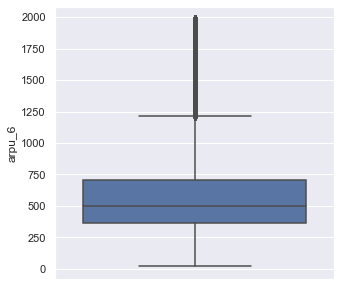

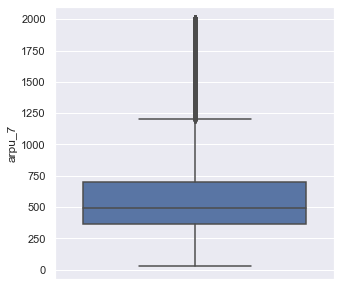

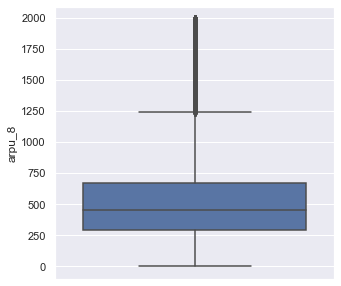

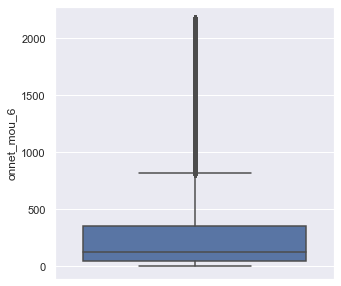

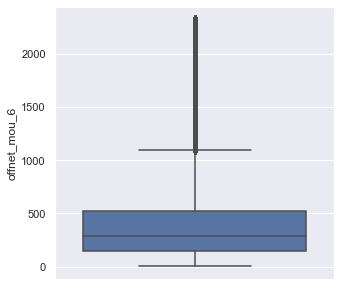

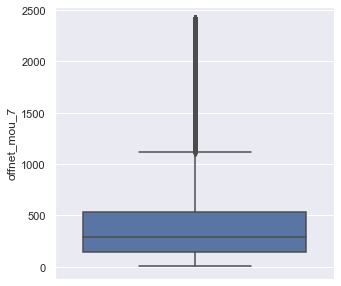

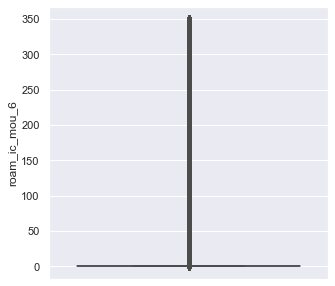

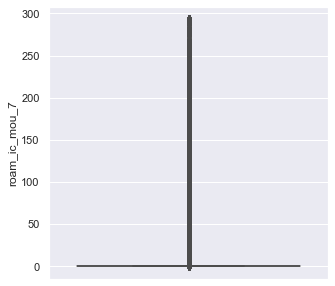

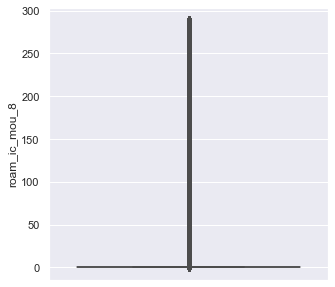

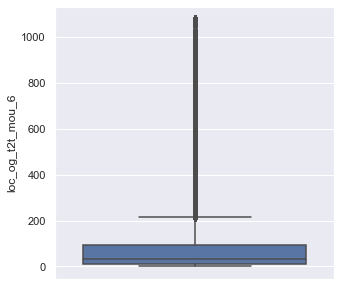

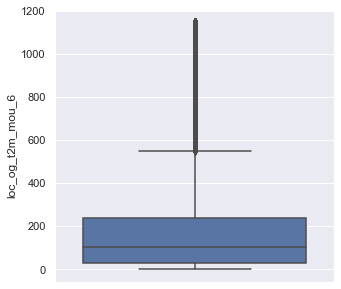

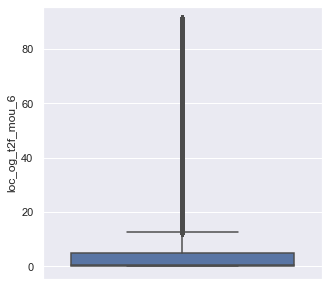

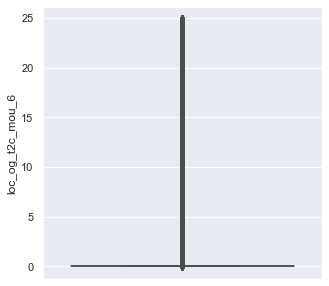

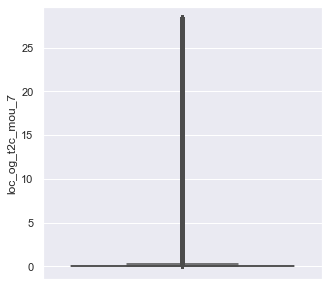

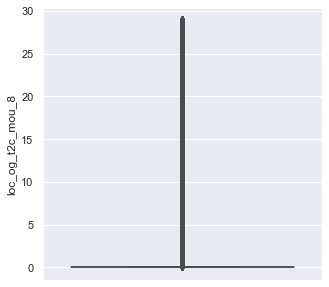

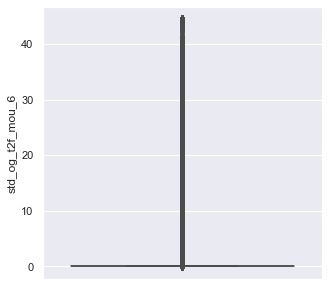

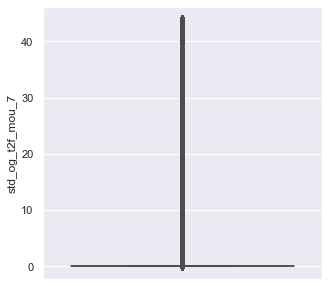

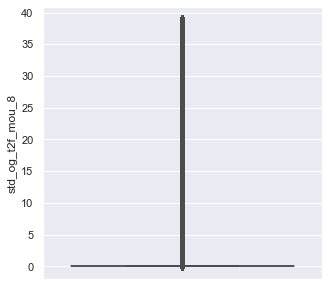

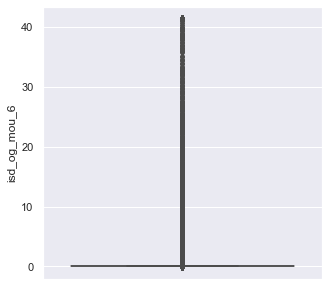

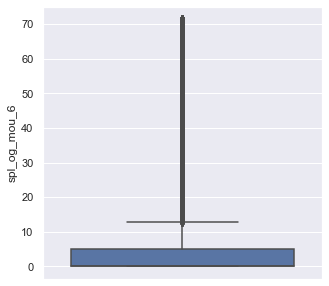

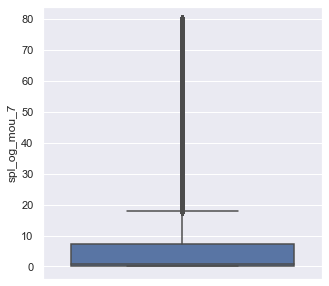

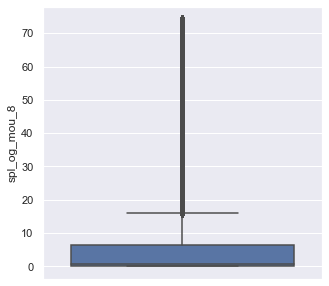

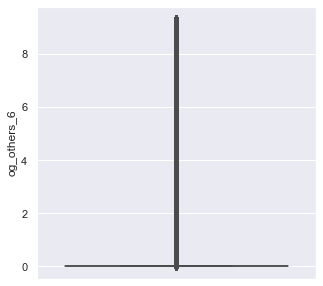

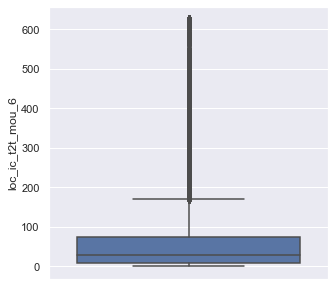

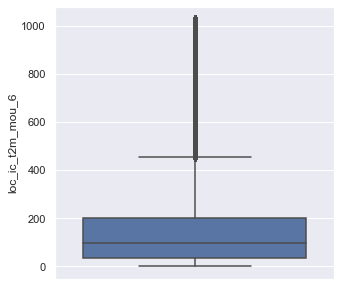

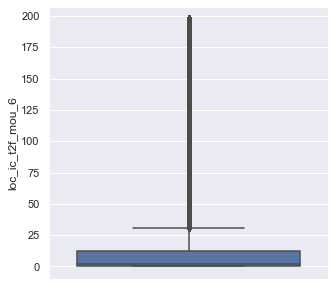

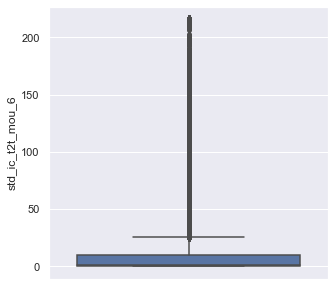

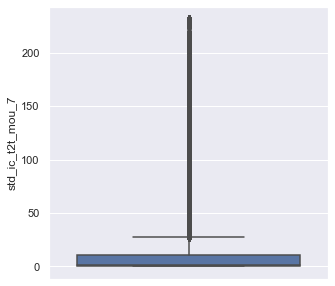

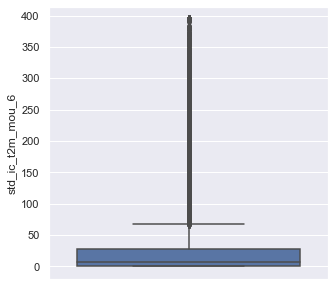

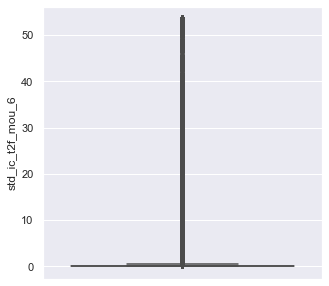

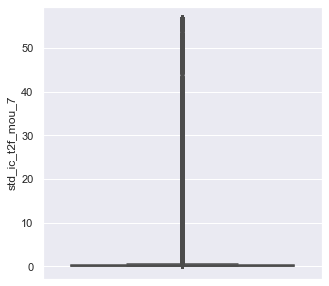

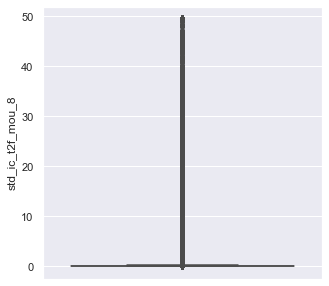

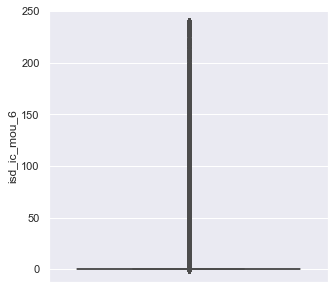

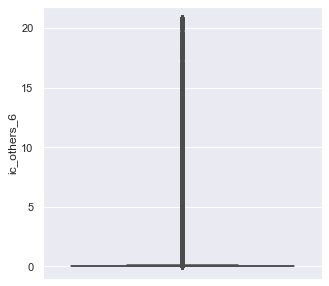

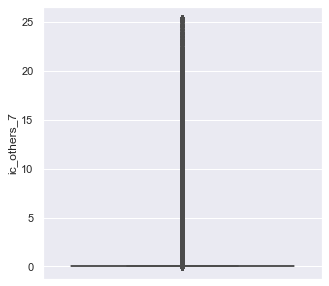

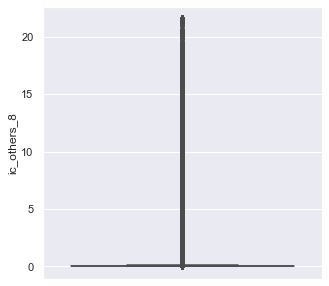

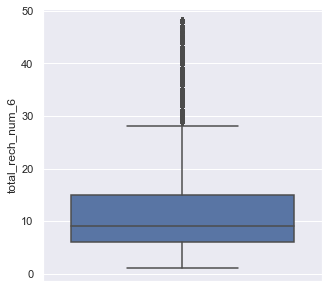

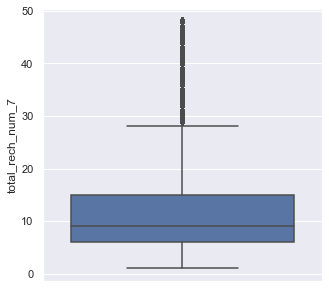

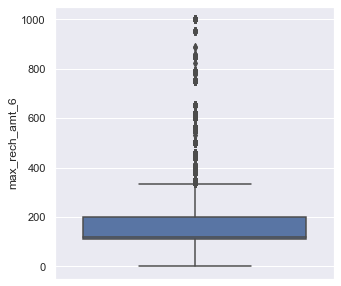

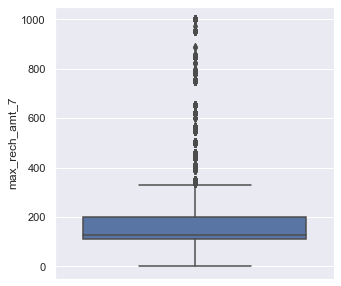

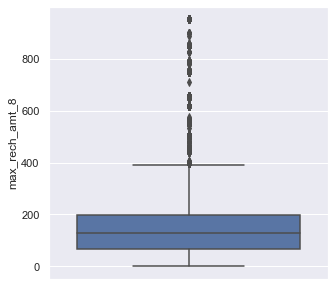

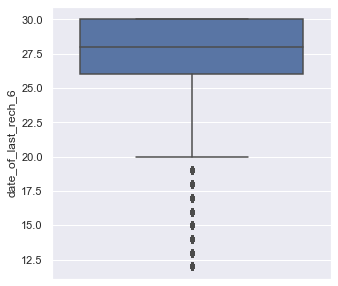

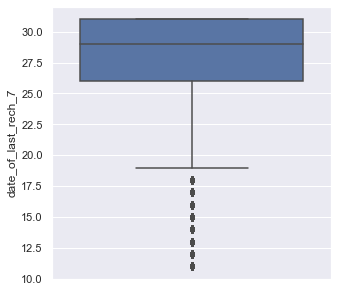

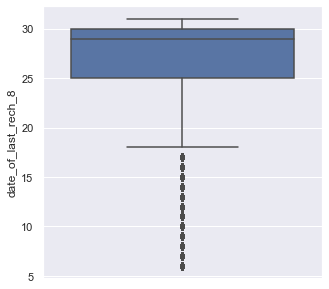

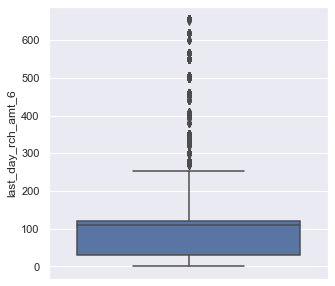

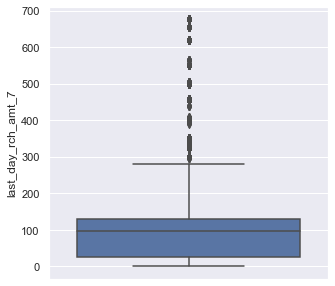

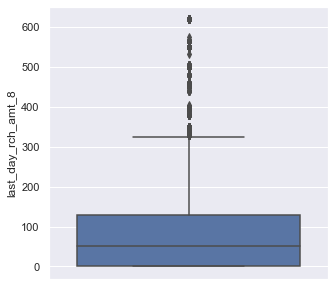

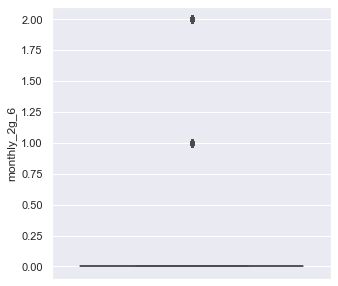

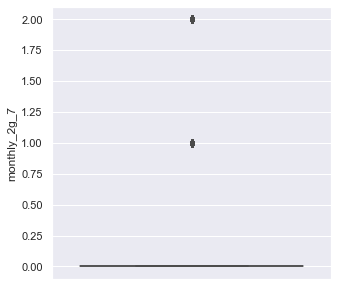

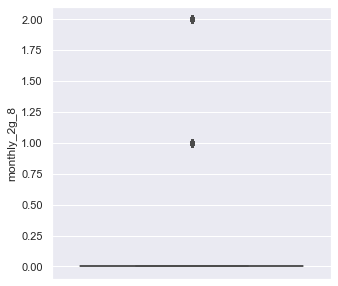

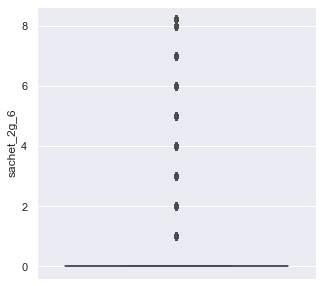

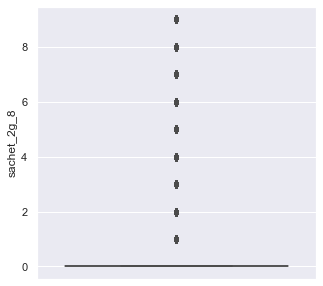

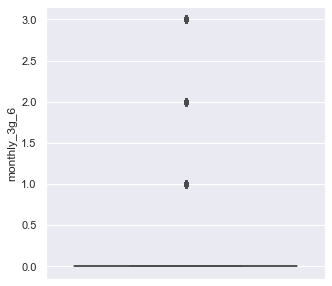

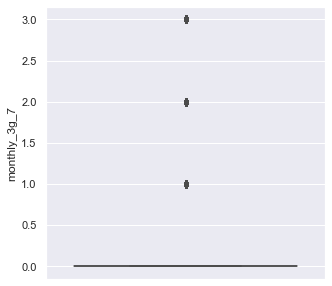

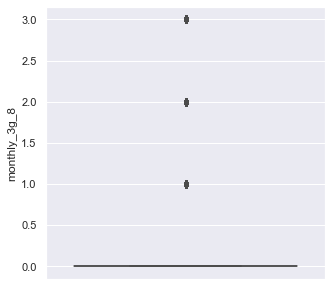

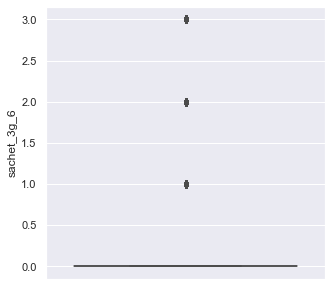

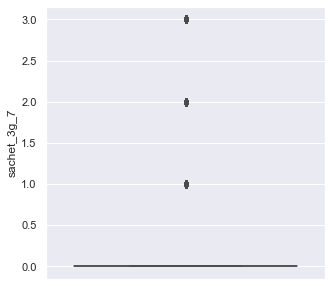

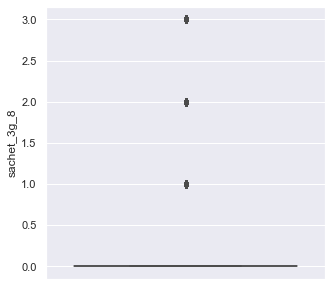

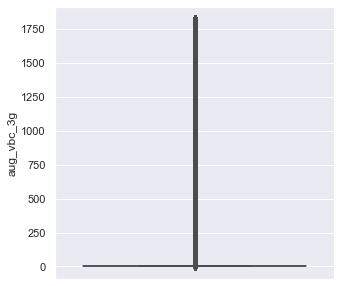

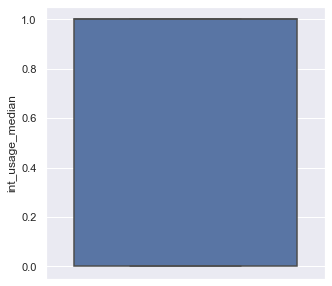

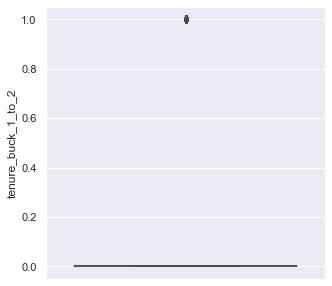

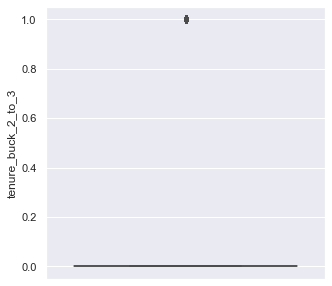

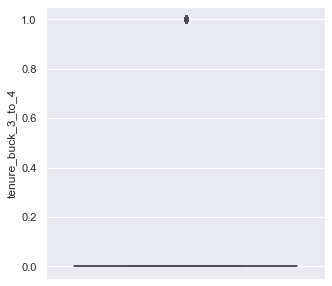

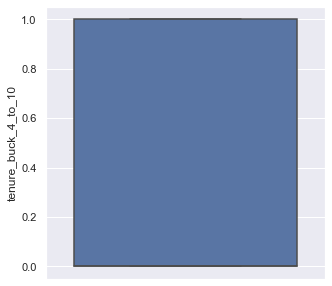

In [38]:
cont_cols = [col for col in telecom_df4.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=col, data=telecom_df4)

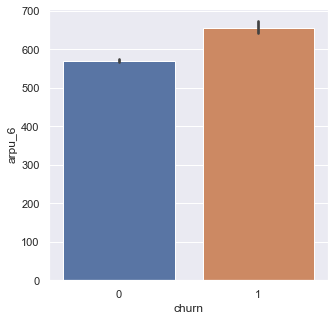

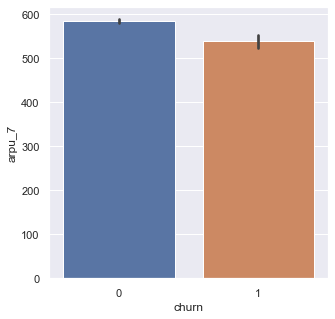

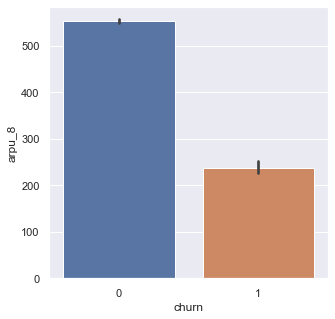

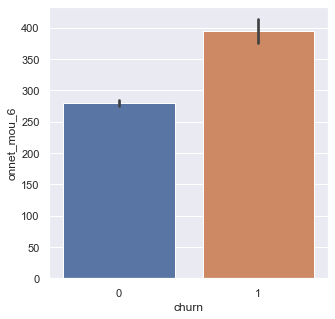

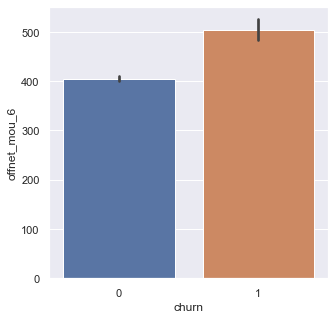

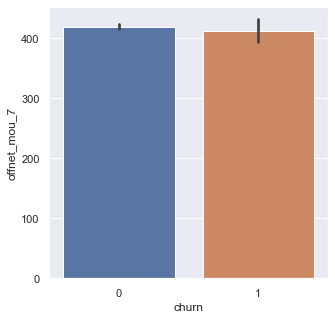

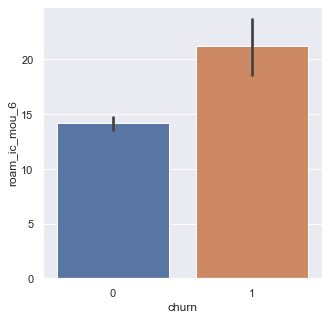

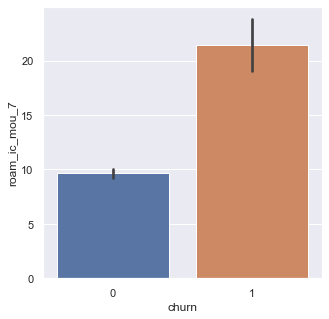

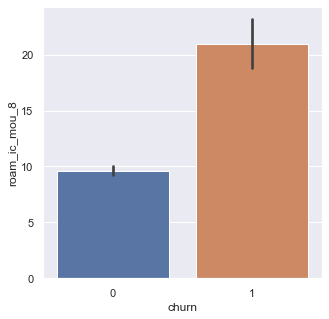

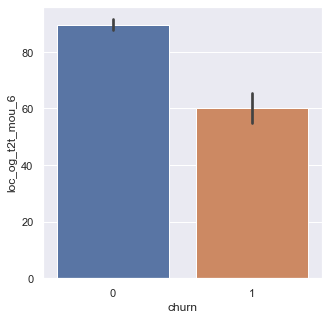

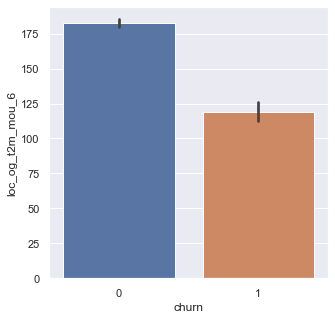

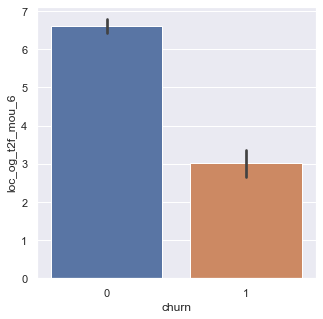

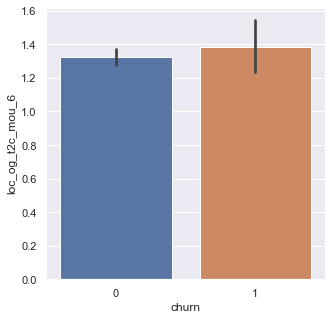

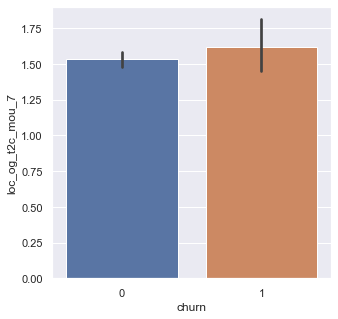

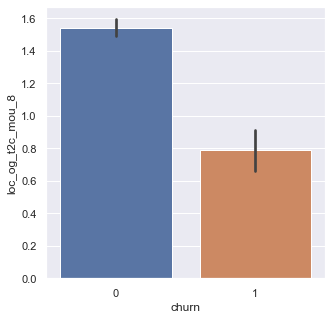

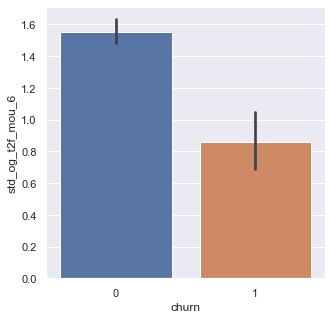

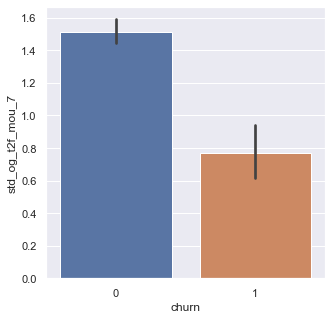

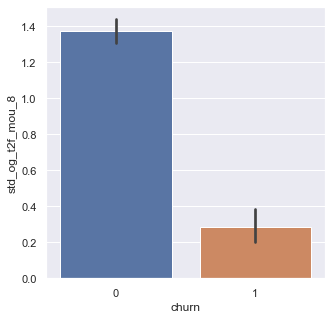

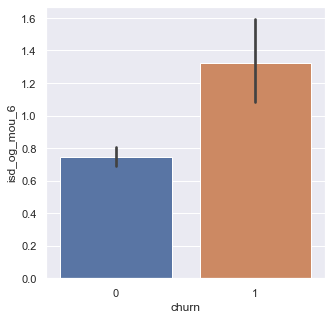

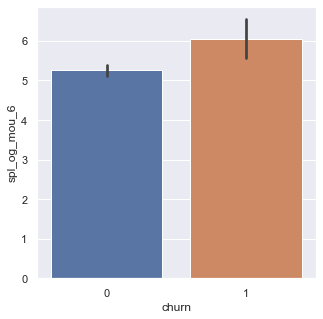

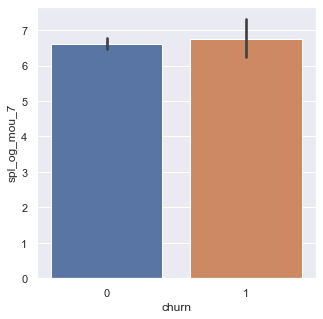

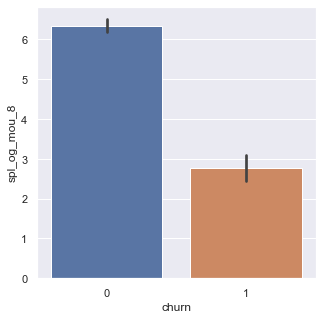

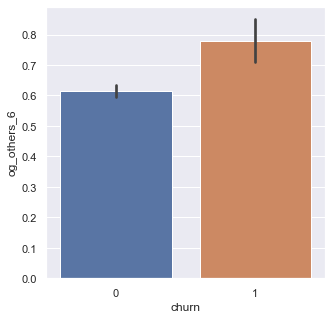

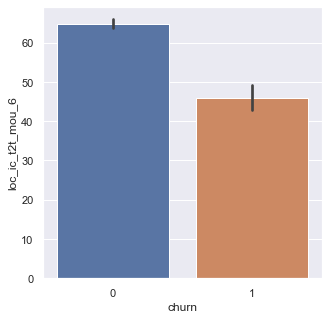

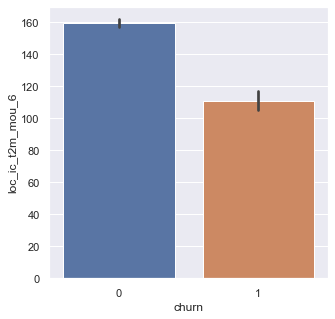

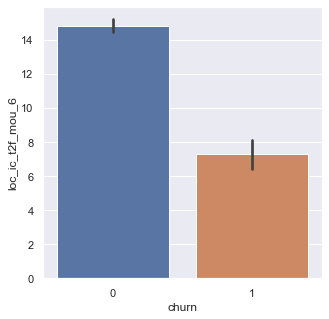

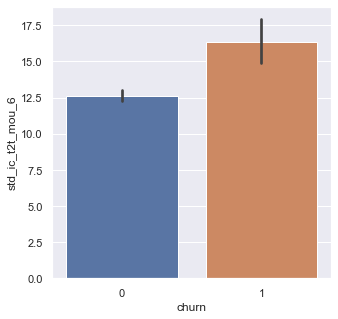

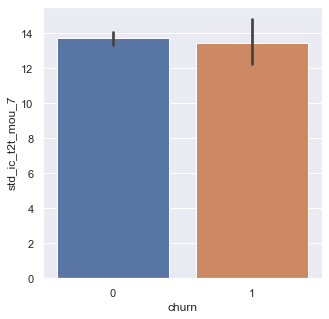

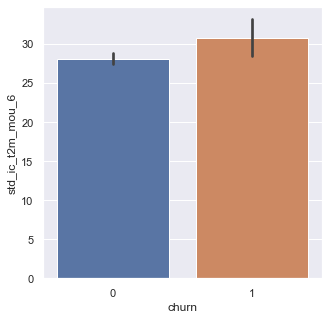

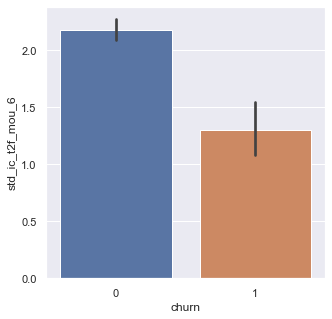

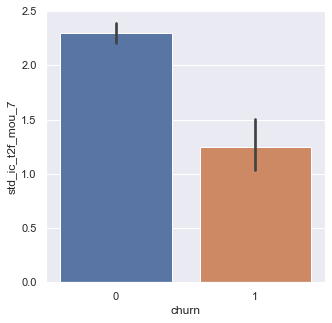

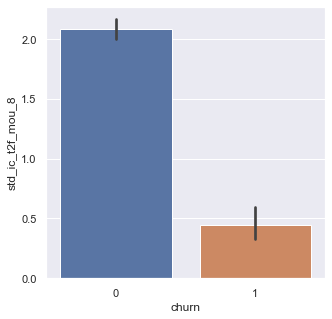

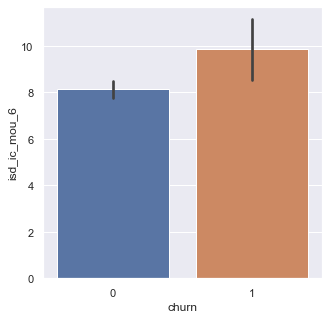

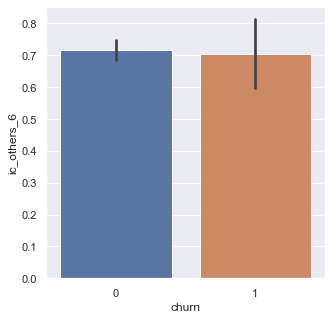

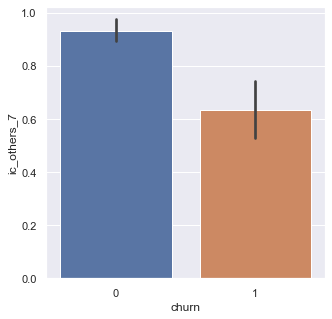

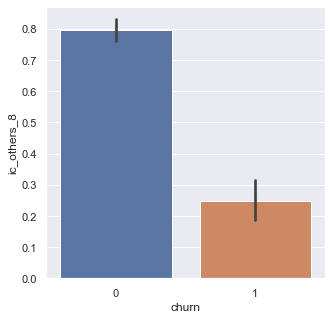

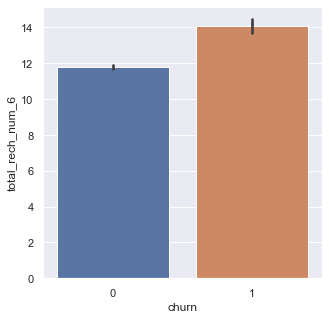

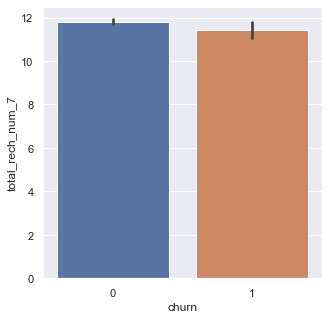

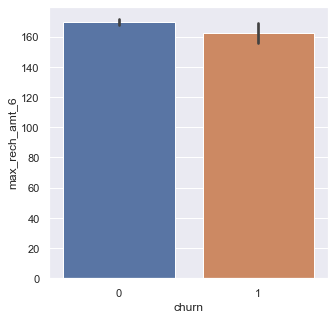

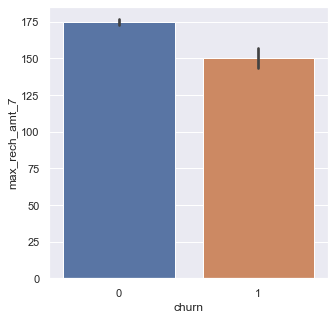

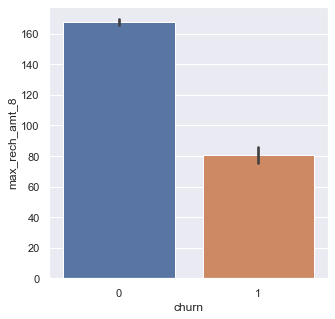

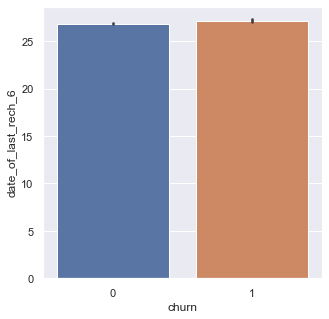

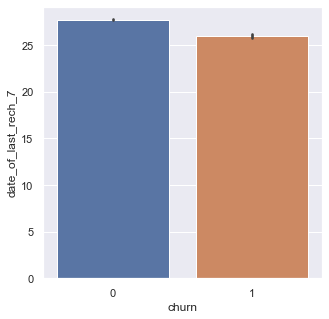

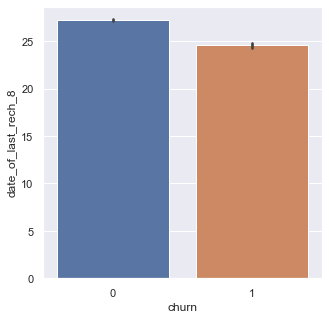

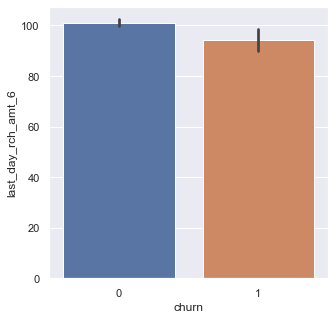

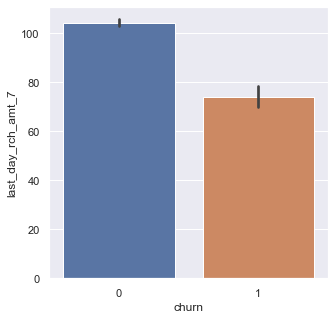

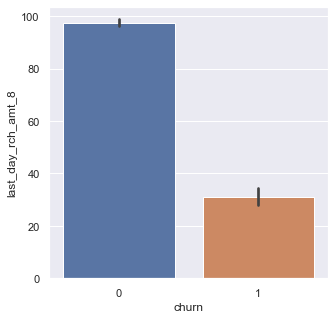

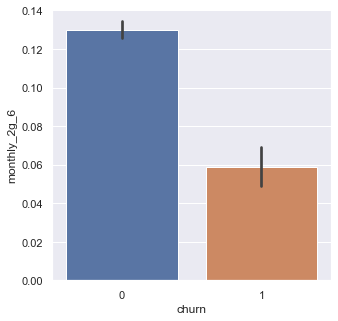

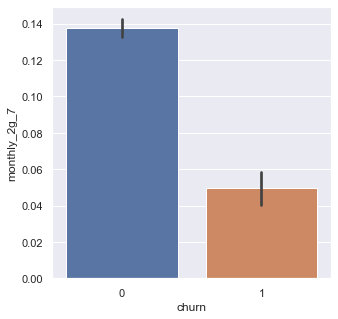

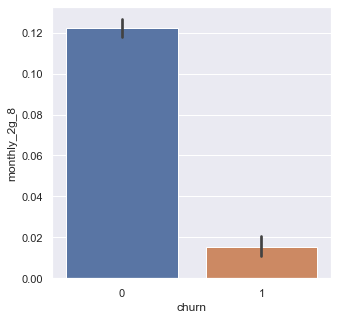

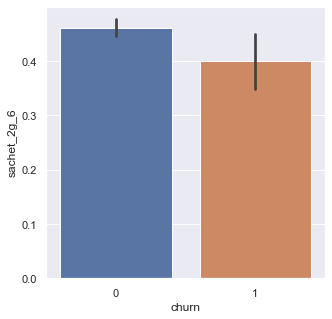

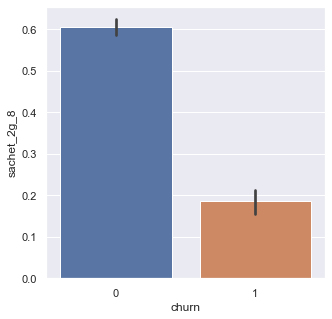

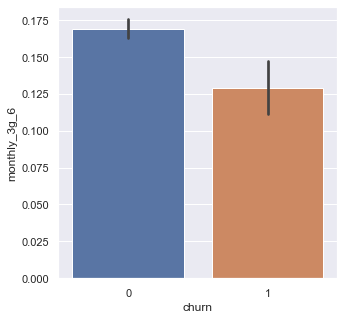

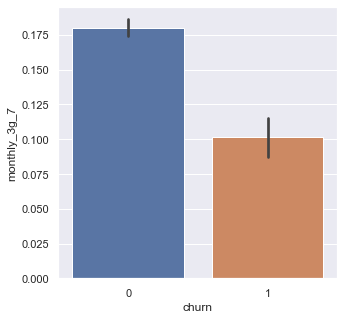

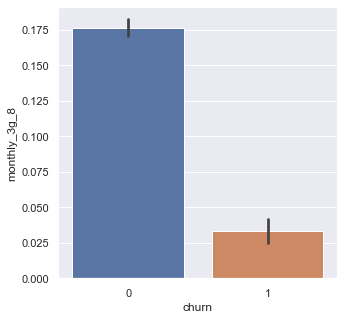

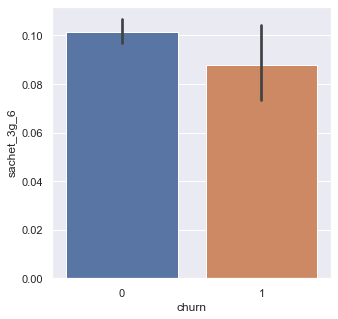

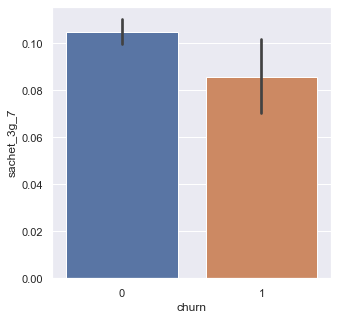

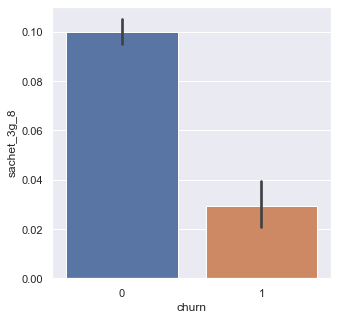

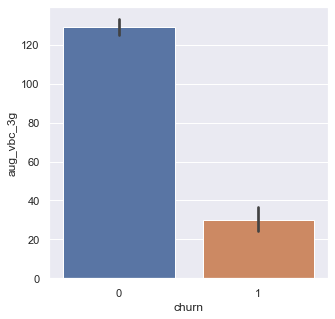

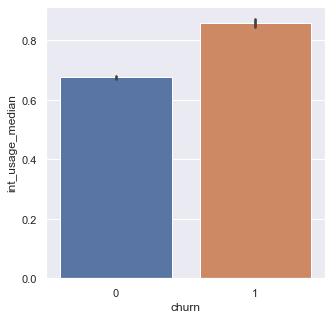

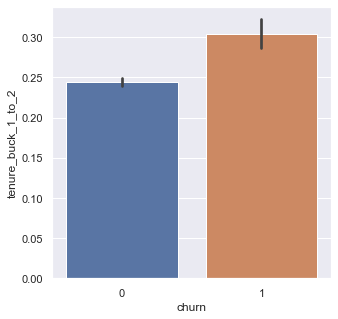

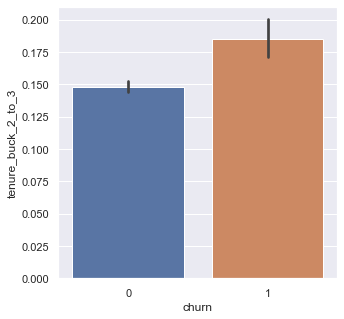

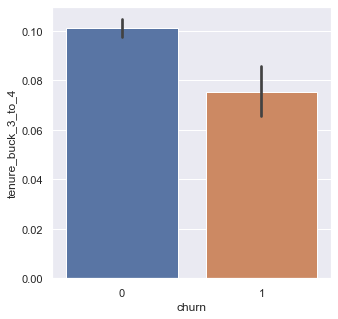

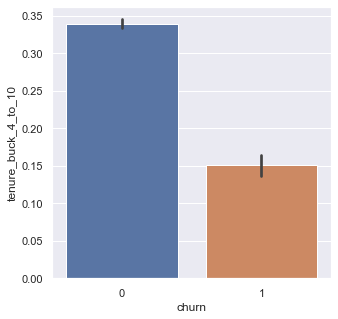

In [39]:
cont_cols = [col for col in telecom_df4.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.barplot(x='churn', y=col, data=telecom_df4)
    plt.show()


[Text(0, 0.5, '(%)')]

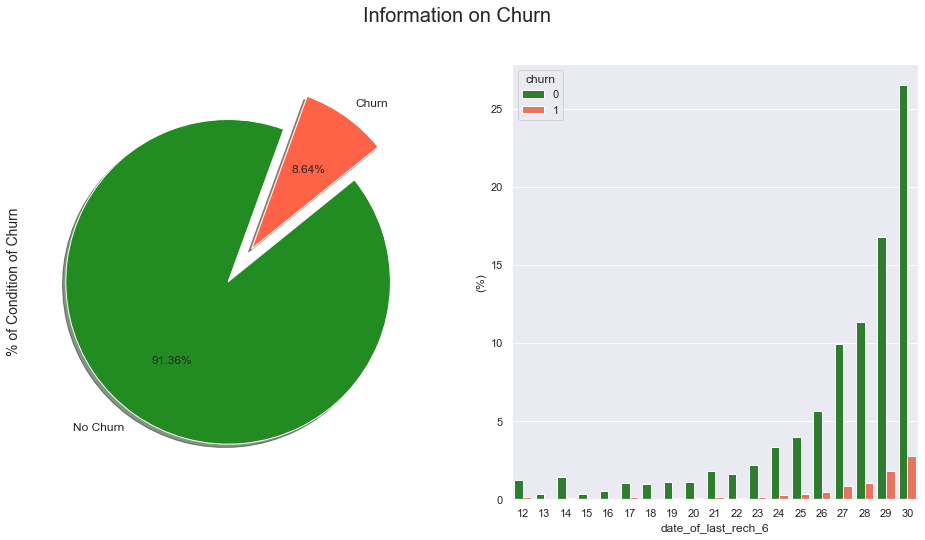

In [40]:
f, ax = plt.subplots(1,2, figsize=(16,8))
colors = ["#228B22", "#FF6347"]

labels ="No Churn", "Churn"
plt.suptitle('Information on Churn', fontsize=20)

telecom_df4["churn"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)
ax[0].set_ylabel('% of Condition of Churn', fontsize=14)

palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_6", y="churn", hue="churn", data=telecom_df4, palette=palette, estimator=lambda x: len(x) / len(telecom_df4) * 100)
ax[1].set(ylabel="(%)")

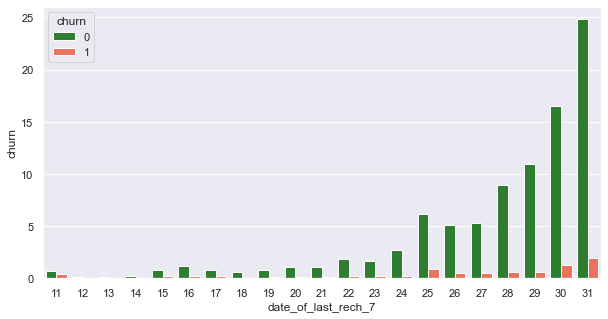

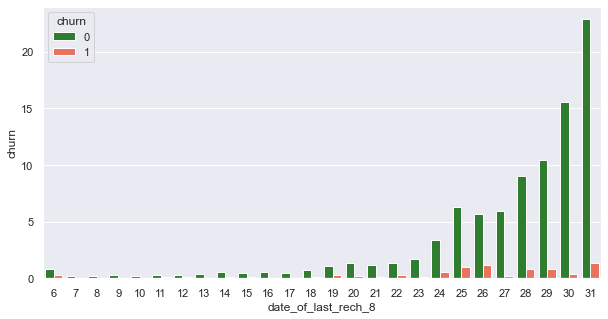

In [41]:
plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_7", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

In [42]:
telecom_df4.shape

(29979, 66)

In [43]:
telecom_df5 = telecom_df4
telecom_df5.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,isd_ic_mou_6,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,churn,int_usage_median,tenure_buck_1_to_2,tenure_buck_2_to_3,tenure_buck_3_to_4,tenure_buck_4_to_10
7,7000701601,1069.180,1349.8500,1988.08226,57.84,453.43,567.160,16.23,33.49,31.64,51.39,308.63,62.13,0.0,0.0,0.00,6.66,20.08,16.68,0.0,4.50,0.00,6.50,0.00,58.14,217.56,152.16,36.89,11.83,91.44,52.19,34.24,22.21,2.060,15.7400,15.19,15.14,5,5,1000,790,951,27,25,26,0,0.0,619,0,0,0,0.0,0,0,0,0,0,0,0,57.74,1,1,0,1,0,0
8,7001524846,378.721,492.2230,137.36200,413.69,94.66,80.630,0.00,0.00,0.00,297.13,80.96,0.00,0.0,0.0,7.15,0.00,0.00,0.00,0.0,0.00,0.00,10.23,0.00,23.84,57.58,0.00,0.00,0.58,22.43,0.00,0.00,0.00,0.000,0.0000,0.00,0.00,19,21,90,154,30,25,31,30,50,0.0,10,0,1,0,0.0,3,0,0,0,0,0,0,21.03,0,0,0,0,0,0
13,7002191713,492.846,205.6710,593.26000,501.76,413.31,119.280,23.53,144.24,72.11,49.63,151.13,4.54,0.0,0.0,0.49,0.00,0.00,0.00,0.0,0.00,0.00,4.78,0.00,67.88,142.88,4.81,115.68,38.29,308.13,0.00,0.00,1.91,239.192,20.7408,16.24,21.44,6,4,110,110,130,20,22,30,110,50.0,0,0,0,0,0.0,3,0,0,0,0,0,0,0.00,0,1,0,0,0,1
16,7000875565,430.975,299.8690,187.89400,50.51,296.29,229.740,0.00,2.83,0.00,42.61,273.29,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,3.26,5.91,0.00,41.33,226.81,8.71,68.79,78.64,18.68,0.51,0.00,2.18,0.000,0.0000,0.00,0.00,10,6,110,110,130,30,31,14,100,100.0,130,0,0,0,0.0,0,0,0,0,0,0,0,0.00,0,1,1,0,0,0
17,7000187447,690.008,25.6006,25.49900,1185.91,61.64,1.099,0.00,4.76,4.81,38.99,58.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2.58,0.00,0.00,0.93,34.54,47.41,0.00,8.63,0.00,1.28,0.00,0.00,0.00,0.000,0.0000,0.00,0.00,19,2,110,0,30,30,30,25,30,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.00,0,1,1,0,0,0


# Model

In [44]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = telecom_df5.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_df4['churn']

# defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                                                                          
# applying normalize ( ) to all columns 
X_norm = X.apply(normalize) 
X_norm.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,isd_ic_mou_6,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,int_usage_median,tenure_buck_1_to_2,tenure_buck_2_to_3,tenure_buck_3_to_4,tenure_buck_4_to_10
7,0.534739,0.670877,1.000000,0.026693,0.194390,0.234889,0.046432,0.114358,0.109657,0.047732,0.268883,0.683540,0.0,0.0,0.000000,0.149929,0.457072,0.42849,0.0,0.063041,0.000000,0.087659,0.000000,0.092945,0.211929,0.771168,0.171040,0.051143,0.232122,0.977323,0.604889,0.449504,0.008612,0.758891,0.601189,0.703205,0.085106,0.085106,1.00,0.790,1.000000,0.833333,0.70,0.80,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031678,1.0,0.0,1.0,0.0,0.0
8,0.183426,0.236395,0.069093,0.190915,0.040222,0.033002,0.000000,0.000000,0.000000,0.275980,0.070534,0.000000,0.0,0.0,0.247557,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.137962,0.000000,0.038112,0.056090,0.000000,0.000000,0.002507,0.056939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382979,0.425532,0.09,0.154,0.031546,0.722222,1.00,0.96,0.076336,0.000000,0.016155,0.0,0.5,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.011538,0.0,0.0,0.0,0.0,0.0
13,0.241494,0.091225,0.298408,0.231559,0.177150,0.049040,0.067316,0.492536,0.249916,0.046097,0.131667,0.049948,0.0,0.0,0.016965,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.064463,0.000000,0.108516,0.139182,0.024378,0.536350,0.165535,0.782194,0.000000,0.000000,0.038656,1.000000,1.000000,0.642746,0.995820,0.106383,0.063830,0.11,0.110,0.136698,0.444444,0.55,0.96,0.167939,0.073975,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,1.0
16,0.210013,0.138947,0.094510,0.023310,0.126865,0.094876,0.000000,0.009664,0.000000,0.039577,0.238094,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.040793,0.079702,0.000000,0.066072,0.220940,0.044144,0.318945,0.339976,0.047420,0.009550,0.000000,0.044121,0.000000,0.000000,0.000000,0.000000,0.191489,0.106383,0.11,0.110,0.136698,1.000000,1.00,0.32,0.152672,0.147951,0.210016,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0
17,0.341812,0.000000,0.012826,0.547290,0.026033,0.000000,0.000000,0.016254,0.016670,0.036215,0.051001,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.036144,0.000000,0.000000,0.099845,0.055217,0.046183,0.000000,0.040013,0.000000,0.003249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382979,0.021277,0.11,0.000,0.031546,1.000000,0.95,0.76,0.045802,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size=0.7,test_size=0.3,random_state=100)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (20985, 64)
Number transactions y_train dataset:  (20985,)
Number transactions X_test dataset:  (8994, 64)
Number transactions y_test dataset:  (8994,)


In [46]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 1774
Before OverSampling, counts of label '0': 19211 



## PCA

In [49]:
pca = PCA(svd_solver='randomized', random_state=42)
#Doing the PCA on the train data
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

In [50]:
print(pca.components_)
colnames = list(X_train.columns)

pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 
                       'PC3':pca.components_[2],'PC4':pca.components_[3],
                       'PC5':pca.components_[4],'PC6':pca.components_[5],
                       'PC7':pca.components_[6],'PC8':pca.components_[7],
                       'PC9':pca.components_[8],'PC10':pca.components_[9],
                       'Feature':colnames})
pcs_df.head(10)

[[ 2.72571622e-02  3.06854554e-02  5.65711713e-02 ... -1.09443676e-01
  -3.84465767e-02  6.33309364e-01]
 [ 4.18919185e-02  6.04983344e-02  6.45280251e-02 ...  2.57138042e-02
   2.31317494e-02 -4.20050004e-01]
 [ 8.86256922e-03  9.48370467e-03  4.45679598e-03 ...  6.41718066e-01
   1.67836011e-01 -2.97419368e-01]
 ...
 [ 2.69357152e-01  3.88331192e-01 -2.99271458e-01 ... -4.22804574e-03
  -6.00330154e-03 -6.33031438e-03]
 [ 4.63600978e-02  2.09811249e-01 -5.38352863e-02 ...  3.89643721e-03
   9.19224613e-04  1.58662910e-04]
 [-5.87486566e-01  4.24434348e-01  1.24821513e-02 ... -8.03315916e-04
   3.30260691e-03  3.77712162e-03]]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Feature
0,0.027257,0.041892,0.008863,-0.025435,0.335408,0.044947,-0.024222,-0.080813,0.004581,-0.160256,arpu_6
1,0.030685,0.060498,0.009484,-0.020675,0.347231,0.045479,0.079954,-0.089717,-0.175575,0.102712,arpu_7
2,0.056571,0.064528,0.004457,-0.009289,0.346802,0.049026,0.088463,-0.094216,-0.195551,0.167722,arpu_8
3,-0.065349,-0.031810,0.015726,-0.059189,0.123000,0.019024,0.060688,-0.006283,-0.035818,-0.103210,onnet_mou_6
4,-0.032633,-0.034933,0.001565,-0.038711,0.307944,0.029847,-0.160777,-0.064776,-0.027720,-0.153454,offnet_mou_6
5,-0.035741,-0.027916,0.000547,-0.035917,0.300139,0.031298,-0.078869,-0.061954,-0.160808,0.032320,offnet_mou_7
6,0.006708,-0.001702,-0.000626,0.033961,0.037511,0.007292,0.059131,-0.039549,-0.085224,0.128832,roam_ic_mou_6
7,0.005179,-0.001149,0.001450,0.037433,0.041556,0.008020,0.037241,-0.038351,-0.057769,0.103260,roam_ic_mou_7
8,0.006896,0.003539,0.001819,0.029578,0.054982,0.005929,0.029720,-0.036005,-0.057183,0.103875,roam_ic_mou_8
9,0.028991,-0.012582,-0.001600,-0.026885,0.097241,0.012368,-0.084338,-0.010365,0.095078,-0.165310,loc_og_t2t_mou_6


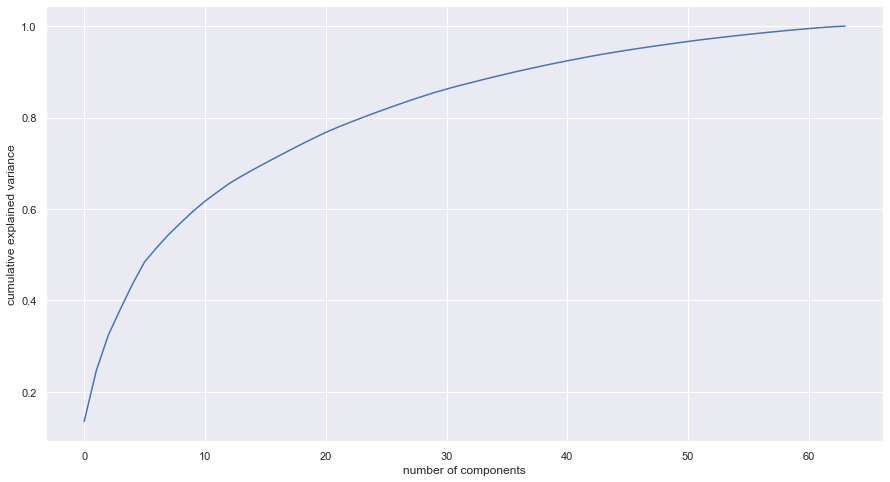

In [51]:
%matplotlib inline
fig = plt.figure(figsize = (15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [52]:
pca_final = IncrementalPCA(n_components=40)

df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(20985, 40)

In [53]:
corrmat = np.corrcoef(df_train_pca.transpose())

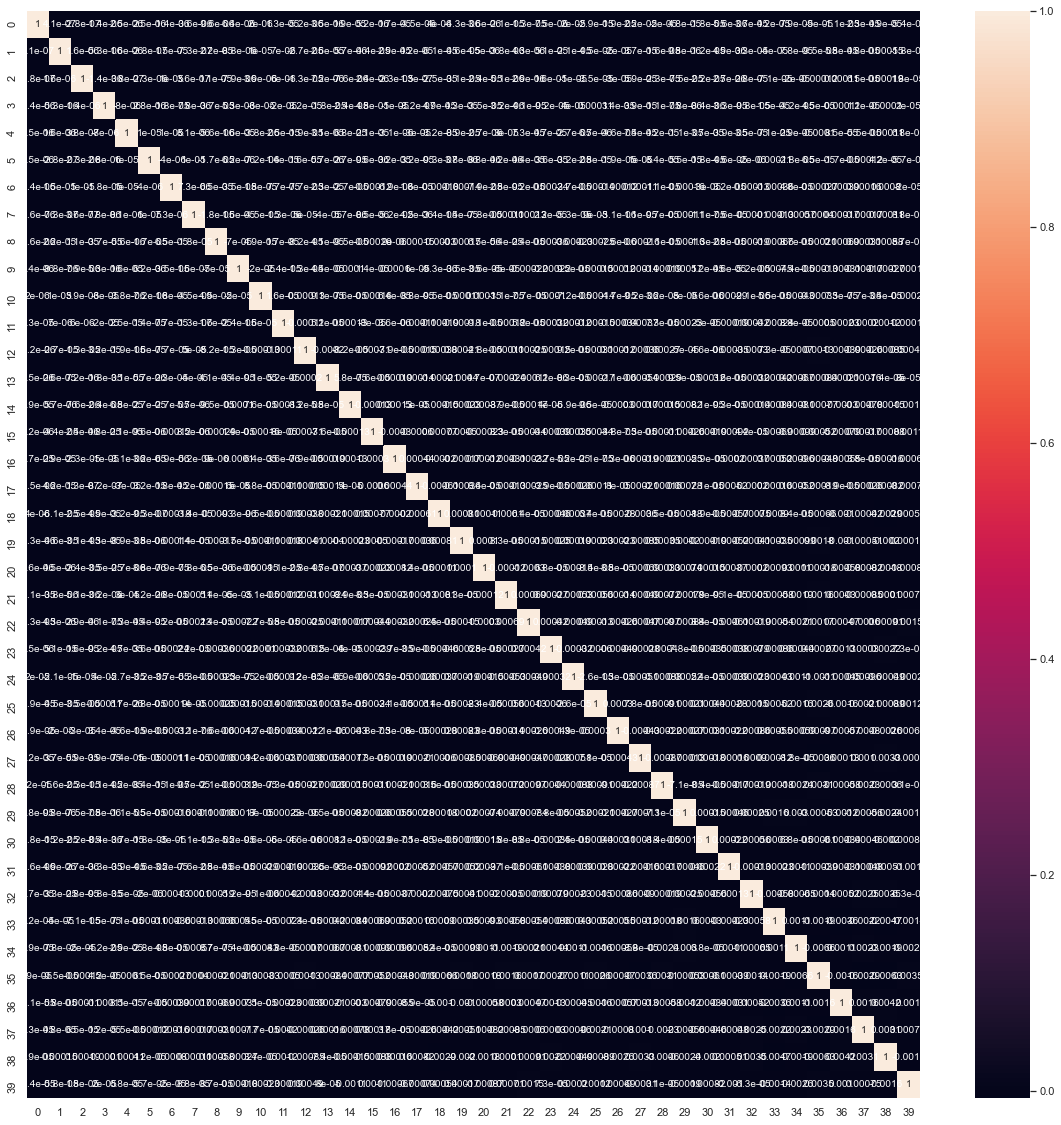

In [54]:
plt.figure(figsize = (20,20))
sns.heatmap(corrmat,annot = True)

In [55]:
### checking correlation values, across non-diagonal areas
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)

max corr: 0.004195136733310091 , min corr:  -0.006584089476795972


## Observation
There is very little correlation between the data as we can see above

In [56]:
#Applying selected components to the test data - 20 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8994, 40)

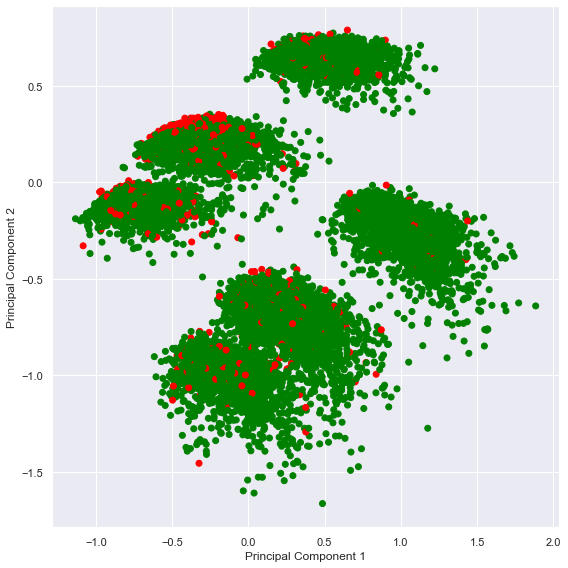

In [57]:
# generate scatter plot to see PCA 1 & 2
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

### Logistic Regression with PCA
Now lets do the modeling with selected 40 pca feature
We also needs to do the class imbalance with class_width = balanced

In [58]:
learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(df_train_pca,y_train)

In [59]:
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.87'

In [60]:
#Making prediction on the test data
pred_test = model_pca.predict_proba(df_test_pca)
y_pred_default = model_pca.predict(df_test_pca)

In [61]:
# print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[6641 1538]
 [ 160  655]]
0.8112074716477652


In [62]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})


In [63]:
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC score: ',roc_auc)

ROC_AUC score:  0.8675136159714726


### ROC CURVE

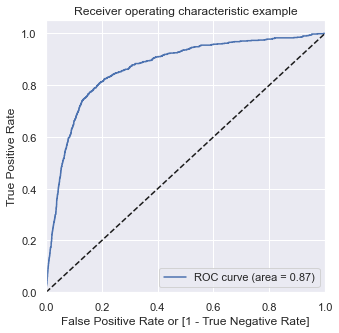

In [64]:
draw_roc(y_pred_final.churn, y_pred_final.churn_prob)

In [65]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.048375,1,0,0,0,0,0,0,0,0,0
1,0,0.165179,1,1,0,0,0,0,0,0,0,0
2,0,0.158834,1,1,0,0,0,0,0,0,0,0
3,0,0.281039,1,1,1,0,0,0,0,0,0,0
4,0,0.512641,1,1,1,1,1,1,0,0,0,0


In [66]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.090616  0.000000  1.000000
0.1   0.1  0.326885  0.262502  0.973006
0.2   0.2  0.503224  0.458858  0.948466
0.3   0.3  0.633422  0.605942  0.909202
0.4   0.4  0.739048  0.727351  0.856442
0.5   0.5  0.811207  0.811957  0.803681
0.6   0.6  0.864020  0.878225  0.721472
0.7   0.7  0.886702  0.914904  0.603681
0.8   0.8  0.904603  0.950972  0.439264
0.9   0.9  0.910496  0.979337  0.219632


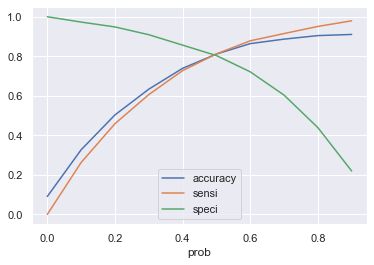

In [67]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [68]:
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_pred_final.churn,y_pred_final.churn_prob)
print('Threshold: ',threshold)

Threshold:  [0.4927312227773504]


In [69]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()

0    8179
1     815
Name: churn, dtype: int64

In [70]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

array([[6590, 1589],
       [ 155,  660]], dtype=int64)

### Logistic Regression model matrics wit PCA -

In [71]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.8112074716477652
Sensitivity:  0.8098159509202454
Specificity:  0.8057219709010881
false postive rate:  0.19427802909891184
positive predictive value:  0.2934637616718542
Negative predictive value:  0.9770200148257969
Misclassification Rate:  0.1939070491438737


## LogistcRegression model with RFE
- As we have seen with PCA we select 40 component.
- We are selecting 10 feature from RFE

In [72]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 10)             # running RFE with 40 variables as output as PCA gave 40
rfe = rfe.fit(X_norm,y)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)           # Printing the ranking

[ True  True  True False False False False False  True False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False  True False
 False  True False  True False False  True False False False False False
 False False False False]
[ 1  1  1 26 24 55 20 19  1  7  1  4 35 43 29 32 17  9 25 52 30  6 51 31
 54 13 38 40 39 48 27  2 12 53 47  8 46 45 21  5 50 33 10  1 34 16  1 18
 44  1 28  1 36 23  1 49 15 14  3 37 41 42 22 11]


In [73]:
col = X_train.columns[rfe.support_]
col

Index(['arpu_6', 'arpu_7', 'arpu_8', 'roam_ic_mou_8', 'loc_og_t2m_mou_6',
       'date_of_last_rech_8', 'last_day_rch_amt_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8'],
      dtype='object')

In [74]:
import statsmodels.api as sm
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### Correlation matrix

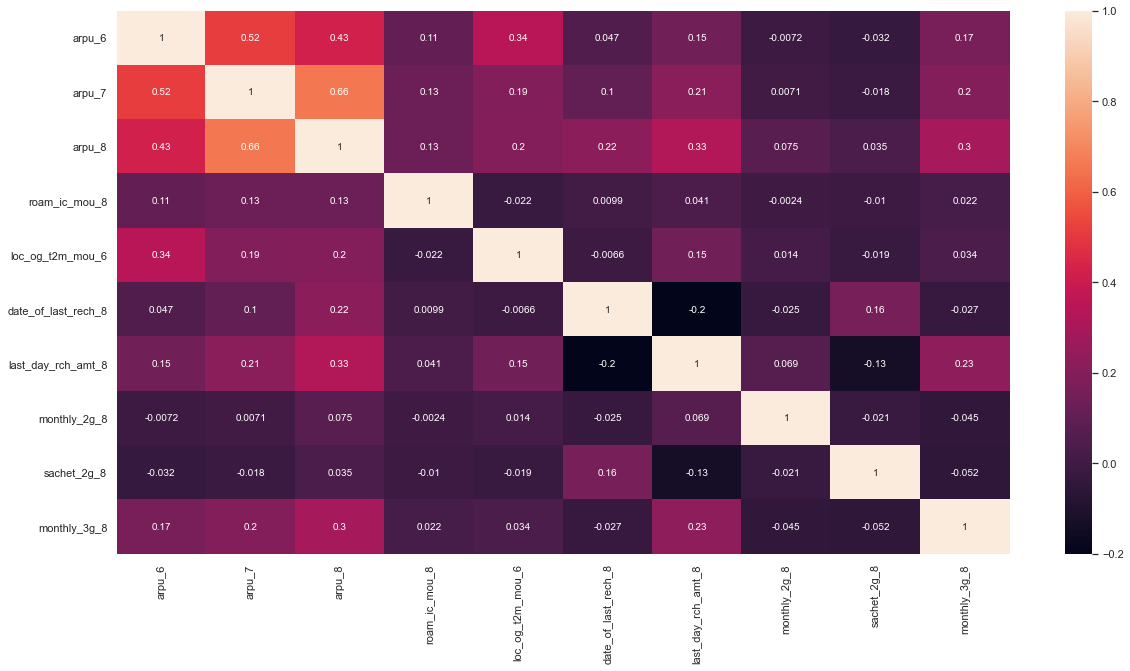

In [75]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X_norm[col].corr(),annot = True)

### VIF value

In [76]:
col_for_vif = list(col)
col_for_vif.append('churn')
# telecom_df4.head()
vif_cal(input_data=telecom_df4[col_for_vif], dependent_col='churn')

,Var,Vif
1,arpu_7,7.78
2,arpu_8,6.24
0,arpu_6,5.86
5,date_of_last_rech_8,5.15
4,loc_og_t2m_mou_6,1.95
6,last_day_rch_amt_8,1.94
9,monthly_3g_8,1.26
8,sachet_2g_8,1.19
7,monthly_2g_8,1.12
3,roam_ic_mou_8,1.10


- VIF looks good now will select these coloum for creating LogisticRegression

In [77]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(class_weight='balanced')
logsk.fit(X_train[col], y_train)

LogisticRegression(class_weight='balanced')

#### ROC_AUC score

In [78]:
#Making prediction on the test data
pred_probs_test = logsk.predict_proba(X_test[col])[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.86'

In [82]:

#Making prediction on the test data
pred_test = logsk.predict_proba(X_test[col])
y_pred_default = logsk.predict(X_test[col])

In [83]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score : ',accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      8179
           1       0.30      0.81      0.44       815

    accuracy                           0.81      8994
   macro avg       0.64      0.81      0.66      8994
weighted avg       0.92      0.81      0.85      8994

[[6644 1535]
 [ 158  657]]
accuracy_score :  0.8117633978207695


In [84]:

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})


In [85]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC Score: ',roc_auc)

ROC_AUC Score:  0.8641736243574558


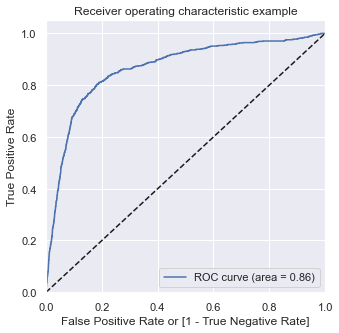

In [86]:
draw_roc(y_pred_final.churn, y_pred_final.churn_prob)

In [87]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()


,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.041235,1,0,0,0,0,0,0,0,0,0
1,0,0.152074,1,1,0,0,0,0,0,0,0,0
2,0,0.336435,1,1,1,1,0,0,0,0,0,0
3,0,0.146296,1,1,0,0,0,0,0,0,0,0
4,0,0.505226,1,1,1,1,1,1,0,0,0,0


In [88]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.090616  0.000000  1.000000
0.1   0.1  0.294196  0.226923  0.969325
0.2   0.2  0.455192  0.405795  0.950920
0.3   0.3  0.600067  0.569263  0.909202
0.4   0.4  0.725150  0.711456  0.862577
0.5   0.5  0.811763  0.812324  0.806135
0.6   0.6  0.862909  0.876024  0.731288
0.7   0.7  0.890371  0.917838  0.614724
0.8   0.8  0.905715  0.955496  0.406135
0.9   0.9  0.911274  0.984595  0.175460


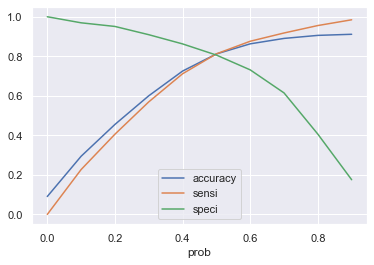

In [89]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [90]:

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_pred_final.churn,y_pred_final.churn_prob)
print('CutOff threshold: ', threshold)

CutOff threshold:  [0.4945581013863592]


In [91]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()


0    8179
1     815
Name: churn, dtype: int64

In [92]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

array([[6583, 1596],
       [ 154,  661]], dtype=int64)

In [93]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score : ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

Accuracy Score :  0.8117633978207695
Sensitivity:  0.811042944785276
Specificity:  0.8048661205526348
false postive rate:  0.1951338794473652
positive predictive value:  0.2928666371289322
Negative predictive value:  0.9771411607540448


## DecisionTreeClassifier With PCA

In [94]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
dt_default.fit(df_train_pca,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

In [95]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(df_test_pca)

# # Printing classification report
# print(classification_report(y_test, y_pred_default))

# from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('Acuracy Score', accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.96      0.81      0.87      8179
           1       0.24      0.62      0.35       815

    accuracy                           0.79      8994
   macro avg       0.60      0.71      0.61      8994
weighted avg       0.89      0.79      0.83      8994

[[6586 1593]
 [ 308  507]]
Acuracy Score 0.7886368690237936


In [96]:
confusion_tree = confusion_matrix(y_test,y_pred_default)
TP = confusion_tree[1,1] # true positive 
TN = confusion_tree[0,0] # true negatives
FP = confusion_tree[0,1] # false positives
FN = confusion_tree[1,0] # false negatives

print('Acuracy Score', accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Acuracy Score 0.7886368690237936
Sensitivity:  0.6220858895705521
Specificity:  0.8052329135591149
false postive rate:  0.1947670864408852
positive predictive value:  0.24142857142857144
Negative predictive value:  0.955323469683783
Misclassification Rate:  0.21136313097620635


- As we can see above Sensitivity of model is not great let's tune the Hyperparameter

## Hyperparameter tuning

In [97]:
########## lets tune hyper parameterss
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", class_weight='balanced', random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=100),
             param_grid={'max_depth': range(1, 40)}, return_train_score=True,
             scoring='accuracy')

In [98]:
y_train.shape

(20985,)

In [99]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.062839,0.001542,0.000995,0.000003,1,{'max_depth': 1},0.627591,0.553014,0.487253,0.506552,0.542292,0.543340,0.048357,39,0.618239,0.547713,0.492078,0.524541,0.550691,0.546652,0.041496
1,0.114687,0.000892,0.001003,0.000011,2,{'max_depth': 2},0.804861,0.741959,0.752680,0.751966,0.770312,0.764355,0.022215,32,0.806826,0.747736,0.745056,0.763581,0.762688,0.765178,0.022147
2,0.168145,0.001015,0.000993,0.000011,3,{'max_depth': 3},0.750774,0.684060,0.652371,0.595425,0.700024,0.676531,0.051541,38,0.753991,0.697284,0.659876,0.607279,0.698594,0.683405,0.048486
3,0.216223,0.001465,0.000799,0.000399,4,{'max_depth': 4},0.704313,0.774124,0.753395,0.733143,0.749345,0.742864,0.023284,34,0.717417,0.784906,0.772695,0.747260,0.752919,0.755039,0.023170
4,0.260901,0.000785,0.001000,0.000005,5,{'max_depth': 5},0.754110,0.770550,0.745294,0.704074,0.713843,0.737574,0.024923,35,0.769061,0.790088,0.770431,0.722361,0.720574,0.754503,0.027986


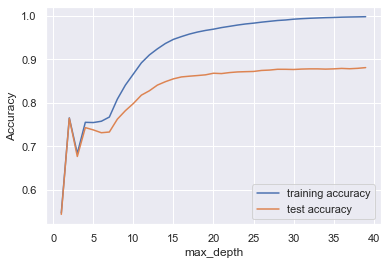

In [100]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# seems 15 or 20 Max depth

In [101]:
## Lets tune min sample leaf
# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini",class_weight='balanced',random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [102]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.498709,0.020931,0.000995,0.000005,5,{'min_samples_leaf': 5},0.835597,0.833452,0.843221,0.847748,0.845127,0.841029,0.005544,1,0.934120,0.936145,0.940851,0.942935,0.937157,0.938242,0.003206
1,0.437432,0.014895,0.000997,0.000002,25,{'min_samples_leaf': 25},0.768168,0.785799,0.755063,0.770074,0.770789,0.769979,0.009764,2,0.833572,0.834108,0.810877,0.822254,0.813974,0.822957,0.009635
2,0.402319,0.011753,0.001003,0.000013,45,{'min_samples_leaf': 45},0.747439,0.750536,0.713367,0.742673,0.739814,0.738766,0.013231,4,0.791339,0.786991,0.770670,0.785919,0.777341,0.782452,0.007437
3,0.380971,0.015817,0.001003,0.000011,65,{'min_samples_leaf': 65},0.730045,0.739338,0.724565,0.730760,0.758637,0.736669,0.011958,5,0.763879,0.773707,0.764892,0.771563,0.784489,0.771706,0.007418
4,0.364434,0.012626,0.000995,0.000006,85,{'min_samples_leaf': 85},0.743626,0.720991,0.741005,0.738146,0.756731,0.740100,0.011479,3,0.772993,0.753097,0.776030,0.771265,0.776328,0.769943,0.008633


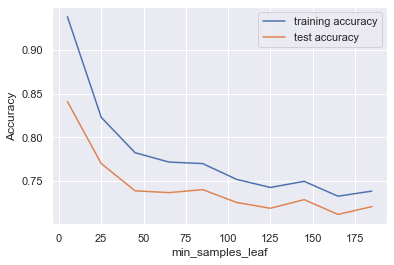

In [103]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 5 to 150

In [104]:
## Tuning min sample split
# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini",class_weight='balanced', random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=100),
             param_grid={'min_samples_split': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [105]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.545546,0.019002,0.000992,0.000005,5,{'min_samples_split': 5},0.877055,0.878008,0.875864,0.882535,0.876102,0.877913,0.002433,1,0.995056,0.993746,0.994877,0.992792,0.994103,0.994115,0.000819
1,0.542954,0.026967,0.000998,0.000001,25,{'min_samples_split': 25},0.830117,0.832976,0.826305,0.832499,0.827258,0.829831,0.002689,2,0.935907,0.934656,0.926376,0.927031,0.922623,0.929319,0.005111
2,0.530580,0.016869,0.001196,0.000397,45,{'min_samples_split': 45},0.807958,0.798427,0.789373,0.799857,0.795568,0.798237,0.006047,3,0.893376,0.882595,0.873600,0.878723,0.868180,0.879295,0.008550
3,0.510436,0.017341,0.001395,0.000486,65,{'min_samples_split': 65},0.783655,0.781511,0.767215,0.776269,0.775316,0.776793,0.005719,4,0.854896,0.851025,0.843936,0.847272,0.836193,0.846664,0.006391
4,0.499864,0.017323,0.000996,0.000001,85,{'min_samples_split': 85},0.770550,0.761496,0.758875,0.761496,0.758875,0.762259,0.004308,5,0.829342,0.824934,0.827972,0.823267,0.816833,0.824470,0.004381


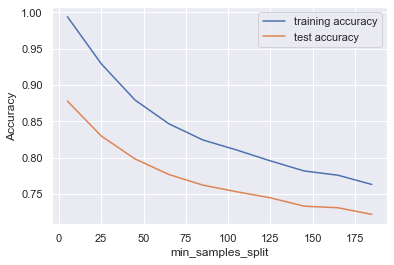

In [106]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 25

In [107]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(5, 200, 20),
    'min_samples_split': range(5, 200, 20),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, refit='recall_score',
                          cv = n_folds, verbose = 1, n_jobs = -1)

# Fit the grid search to the data
grid_search.fit(df_train_pca,y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.7min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(5, 200, 20),
                         'min_samples_split': range(5, 200, 20)},
             refit='recall_score', verbose=1)

In [108]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.812826,0.063302,0.002194,0.000399,entropy,5,5,5,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.712175,0.730284,0.703598,0.768168,0.732714,0.023703,158
1,0.859502,0.095121,0.002793,0.000746,entropy,5,5,25,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.712175,0.730284,0.703598,0.768168,0.732714,0.023703,158
2,0.857707,0.065733,0.002393,0.000488,entropy,5,5,45,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.712175,0.730284,0.703598,0.768168,0.732714,0.023703,158
3,0.908371,0.084102,0.001397,0.000489,entropy,5,5,65,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.711699,0.726710,0.703598,0.768168,0.731904,0.023899,166
4,0.907972,0.042490,0.001795,0.000399,entropy,5,5,85,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.749345,0.712175,0.726710,0.703598,0.768168,0.731999,0.023819,165


In [109]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.7897545866094828
DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=5)


In [110]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini",class_weight='balanced',
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=5,
                                  min_samples_split=5)
clf_gini.fit(df_train_pca,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=5,
                       random_state=100)

In [111]:
y_pred_default = clf_gini.predict(df_test_pca)
confusion_tree_hyper=confusion_matrix(y_test,y_pred_default)
confusion_tree_hyper

array([[6546, 1633],
       [ 309,  506]], dtype=int64)

In [112]:
TP = confusion_tree_hyper[1,1] # true positive 
TN = confusion_tree_hyper[0,0] # true negatives
FP = confusion_tree_hyper[0,1] # false positives
FN = confusion_tree_hyper[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Sensitivity:  0.6208588957055214
Specificity:  0.8003423401393813
false postive rate:  0.19965765986061865
positive predictive value:  0.23655913978494625
Negative predictive value:  0.9549234135667396
Misclassification Rate:  0.21592172559484102


In [113]:
### Observations to be added

## RandomForestClassifier with PCA

In [114]:
# Random forest

# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

# fit
rfc.fit(df_train_pca,y_train)

# Making predictions
y_pred_default = rfc.predict(df_test_pca)

In [115]:
confusion_rf=confusion_matrix(y_test,y_pred_default)
confusion_rf

array([[8142,   37],
       [ 754,   61]], dtype=int64)

In [116]:
TN = confusion_rf[0,0] # true positive 
TP = confusion_rf[1,1] # true negatives
FP = confusion_rf[0,1] # false positives
FN = confusion_rf[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Sensitivity:  0.07484662576687116
Specificity:  0.9954762195867466
false postive rate:  0.004523780413253454
positive predictive value:  0.6224489795918368
Negative predictive value:  0.9152428057553957
Misclassification Rate:  0.0879475205692684


### Hyperparameter tuning for RandomForest

In [117]:
#Lets do some hyper parameter tuning 
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf_with_pca = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf_with_pca = GridSearchCV(rf_with_pca, parameters, cv=n_folds, scoring="accuracy", n_jobs=-1,
                          return_train_score=True)
rf_with_pca.fit(df_train_pca, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1, param_grid={'max_depth': range(2, 20, 5)},
             return_train_score=True, scoring='accuracy')

In [118]:
# scores of GridSearch CV
scores = rf_with_pca.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.088519,0.020473,0.042287,0.001850,2,{'max_depth': 2},0.768406,0.783178,0.781511,0.774601,0.774124,0.776364,0.005374,4,0.779902,0.788778,0.788003,0.773171,0.775971,0.781165,0.006280
1,6.131958,0.009863,0.057249,0.001016,7,{'max_depth': 7},0.866571,0.874434,0.880629,0.873719,0.880391,0.875149,0.005170,3,0.902609,0.902669,0.903741,0.897784,0.905706,0.902502,0.002612
2,7.999048,0.088781,0.063241,0.006086,12,{'max_depth': 12},0.908744,0.911127,0.919228,0.915416,0.917084,0.914320,0.003853,2,0.977663,0.977484,0.978437,0.974029,0.976650,0.976853,0.001522
3,7.653305,0.328659,0.053974,0.004257,17,{'max_depth': 17},0.913510,0.916369,0.918990,0.919705,0.916607,0.917036,0.002191,1,0.992376,0.993090,0.992554,0.991959,0.992435,0.992483,0.000364


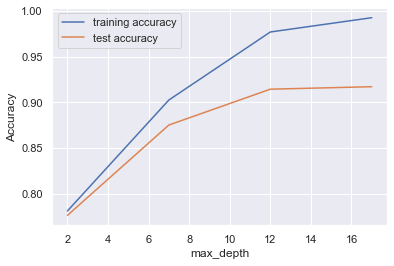

In [119]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 10 to 12

In [120]:
# Tuning n_estimators
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1, return_train_score=True)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=10),
             n_jobs=-1, param_grid={'n_estimators': range(100, 1500, 400)},
             return_train_score=True, scoring='accuracy')

In [121]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.506736,0.286156,0.073406,0.004943,100,{'n_estimators': 100},0.900882,0.904932,0.914939,0.909936,0.908030,0.907744,0.004726,4,0.958721,0.958184,0.958542,0.954670,0.959376,0.957898,0.001660
1,41.829711,0.342643,0.331532,0.002514,500,{'n_estimators': 500},0.901358,0.906362,0.913271,0.910412,0.912080,0.908697,0.004350,2,0.960150,0.960210,0.959554,0.957112,0.961222,0.959650,0.001377
2,68.270717,0.426099,0.506082,0.027354,900,{'n_estimators': 900},0.899929,0.906600,0.914224,0.910889,0.912080,0.908744,0.005061,1,0.960091,0.960210,0.960150,0.957350,0.960269,0.959614,0.001133
3,84.948881,1.591443,0.554650,0.009731,1300,{'n_estimators': 1300},0.900405,0.906838,0.914701,0.909697,0.910174,0.908363,0.004709,3,0.959852,0.959018,0.959137,0.957172,0.960448,0.959126,0.001105


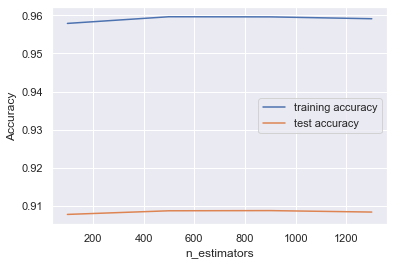

In [122]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [123]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10,class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1, return_train_score=True)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=10),
             n_jobs=-1, param_grid={'max_features': [4, 8, 14, 20, 24]},
             return_train_score=True, scoring='accuracy')

In [124]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.477710,0.073355,0.075798,0.002959,4,{'max_features': 4},0.900643,0.904694,0.912080,0.907076,0.905647,0.906028,0.003705,4,0.957708,0.956040,0.958661,0.953955,0.958244,0.956922,0.001730
1,10.803997,0.304596,0.068923,0.000731,8,{'max_features': 8},0.898499,0.905647,0.915892,0.908983,0.908030,0.907410,0.005609,1,0.958482,0.959078,0.959257,0.956934,0.959733,0.958697,0.000968
2,18.148508,0.174870,0.065551,0.001556,14,{'max_features': 14},0.901120,0.902549,0.914224,0.907076,0.908983,0.906791,0.004697,3,0.962473,0.958304,0.959495,0.958125,0.959971,0.959674,0.001564
3,23.035992,0.616285,0.054906,0.005860,20,{'max_features': 20},0.896593,0.905885,0.910174,0.910650,0.912318,0.907124,0.005677,2,0.961520,0.962711,0.960031,0.957410,0.961937,0.960722,0.001872
4,23.799523,0.939810,0.041748,0.001123,24,{'max_features': 24},0.897069,0.901835,0.910174,0.906838,0.910650,0.905313,0.005187,5,0.961699,0.960031,0.961520,0.957231,0.962294,0.960555,0.001821


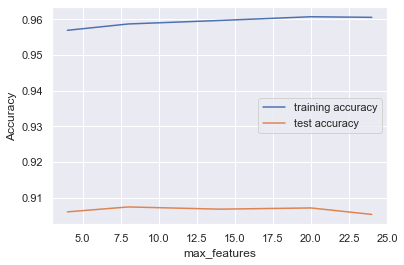

In [125]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 8 to 10

In [126]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1,return_train_score=True)
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1, param_grid={'min_samples_leaf': range(100, 400, 50)},
             return_train_score=True, scoring='accuracy')

In [127]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.596487,0.061010,0.064231,0.001768,100,{'min_samples_leaf': 100},0.853467,0.849893,0.853943,0.858232,0.857041,0.854515,0.002932,1,0.873183,0.876340,0.871396,0.871575,0.874434,0.873386,0.001850
1,6.521285,0.527374,0.065827,0.009073,150,{'min_samples_leaf': 150},0.839409,0.840362,0.840600,0.839409,0.844413,0.840839,0.001852,2,0.854837,0.855194,0.854062,0.851739,0.855909,0.854348,0.001434
2,5.833014,0.287011,0.058444,0.002239,200,{'min_samples_leaf': 200},0.830593,0.827258,0.829164,0.823922,0.838456,0.829878,0.004836,3,0.839290,0.845723,0.843102,0.838754,0.849178,0.843209,0.003929
3,5.749155,0.371125,0.057751,0.010325,250,{'min_samples_leaf': 250},0.825351,0.817489,0.823207,0.817012,0.828687,0.822349,0.004517,4,0.834882,0.832202,0.833274,0.831189,0.836490,0.833607,0.001891
4,5.163766,0.035841,0.043590,0.006736,300,{'min_samples_leaf': 300},0.817250,0.815821,0.822731,0.817727,0.816297,0.817965,0.002476,5,0.830593,0.828449,0.832321,0.826364,0.825590,0.828663,0.002525


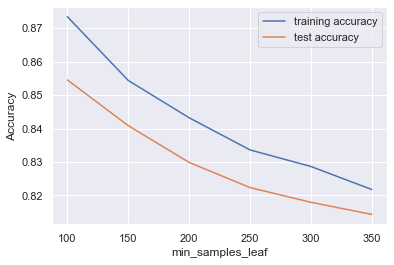

In [128]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#seems 100 to 150

In [129]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="accuracy")
rf.fit(df_train_pca, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'min_samples_split': range(200, 500, 50)},
             return_train_score=True, scoring='accuracy')

In [130]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.125991,0.025910,0.039006,0.000619,200,{'min_samples_split': 200},0.872051,0.873719,0.881820,0.877293,0.875864,0.876150,0.003354,1,0.900941,0.902907,0.901656,0.898797,0.902013,0.901263,0.001386
1,3.976198,0.037552,0.037950,0.000631,250,{'min_samples_split': 250},0.861568,0.859662,0.870384,0.863712,0.863236,0.863712,0.003626,2,0.892364,0.886943,0.890279,0.884680,0.888492,0.888551,0.002649
2,3.865431,0.025776,0.036750,0.000374,300,{'min_samples_split': 300},0.853705,0.852990,0.859900,0.858232,0.857994,0.856564,0.002717,3,0.876817,0.879080,0.879259,0.876579,0.882059,0.878759,0.001988
3,3.748011,0.019054,0.035784,0.000801,350,{'min_samples_split': 350},0.852990,0.850131,0.850369,0.853228,0.854182,0.852180,0.001627,4,0.873838,0.872111,0.867822,0.868954,0.872290,0.871003,0.002247
4,3.641023,0.036862,0.034778,0.000372,400,{'min_samples_split': 400},0.848463,0.839647,0.844651,0.847748,0.849178,0.845938,0.003504,5,0.864725,0.862283,0.860376,0.861389,0.865976,0.862950,0.002089


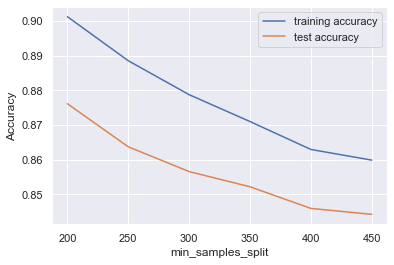

In [131]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 200 to 300

In [132]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [8,10],
    'min_samples_leaf': range(100, 200, 100),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': range(200, 400, 100), 
    'max_features': [8, 10, 12]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 5, n_jobs=-1, verbose = 1, return_train_score=True)

In [133]:
# Fit the grid search to the data
grid_search.fit(df_train_pca, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10], 'max_features': [8, 10, 12],
                         'min_samples_leaf': range(100, 200, 100),
                         'min_samples_split': range(200, 400, 100),
                         'n_estimators': range(200, 400, 100)},
             refit='recall_score', return_train_score=True, verbose=1)

In [134]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8537050274005242 using {'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [135]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=8,
                             n_estimators=300)

In [136]:
# fit
rfc.fit(df_train_pca,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=8,
                       min_samples_leaf=100, min_samples_split=200,
                       n_estimators=300)

In [137]:
# predict
y_pred_default = rfc.predict(df_test_pca)

In [138]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score:  ',accuracy_score(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.96      0.87      0.92      8179
           1       0.35      0.68      0.46       815

    accuracy                           0.86      8994
   macro avg       0.66      0.78      0.69      8994
weighted avg       0.91      0.86      0.88      8994

[[7154 1025]
 [ 264  551]]
accuracy_score:   0.8566822325995108


In [139]:
# Confusion Matrix
confusion_rf_hyper=confusion_matrix(y_test,y_pred_default)
confusion_rf_hyper

array([[7154, 1025],
       [ 264,  551]], dtype=int64)

In [140]:
TN = confusion_rf_hyper[0,0] # true positive 
TP = confusion_rf_hyper[1,1] # true negatives
FP = confusion_rf_hyper[0,1] # false positives
FN = confusion_rf_hyper[1,0] # false negatives

print('Accuracy Score:  ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:   0.8566822325995108
Sensitivity:  0.6760736196319018
Specificity:  0.87467905611933
false postive rate:  0.12532094388067
positive predictive value:  0.3496192893401015
Negative predictive value:  0.9644108924238339
Misclassification Rate:  0.1433177674004892


## RandomForest on all feature

In [141]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

In [142]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced')

In [143]:
# Making predictions
predictions = rfc.predict(X_test)

In [144]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      8179
           1       0.78      0.40      0.52       815

    accuracy                           0.94      8994
   macro avg       0.86      0.69      0.75      8994
weighted avg       0.93      0.94      0.93      8994

[[8089   90]
 [ 493  322]]
0.9351790082277074


In [145]:
# Confusion Matrix
confusion_rf_with_all_feature=confusion_matrix(y_test,predictions)
confusion_rf_with_all_feature

array([[8089,   90],
       [ 493,  322]], dtype=int64)

In [146]:
TN = confusion_rf_with_all_feature[0,0] # true positive 
TP = confusion_rf_with_all_feature[1,1] # true negatives
FP = confusion_rf_with_all_feature[0,1] # false positives
FN = confusion_rf_with_all_feature[1,0] # false negatives

print('Accuracy Score: ', accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:  0.9351790082277074
Sensitivity:  0.3950920245398773
Specificity:  0.9889962098055997
false postive rate:  0.011003790194400294
positive predictive value:  0.7815533980582524
Negative predictive value:  0.9425541831740853
Misclassification Rate:  0.06482099177229264


## Hyperparameter Tuning 

In [147]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1, return_train_score=True)


In [148]:
rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1, param_grid={'max_depth': range(2, 20, 5)},
             return_train_score=True, scoring='accuracy')

In [149]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.065880,0.021681,0.033910,0.000630,2,{'max_depth': 2},0.882297,0.865618,0.886347,0.882297,0.878723,0.879056,0.007139,4,0.890994,0.873838,0.886943,0.879855,0.876579,0.881642,0.006408
1,3.169405,0.026135,0.062990,0.001901,7,{'max_depth': 7},0.901596,0.906123,0.916131,0.913748,0.914224,0.910365,0.005558,3,0.925899,0.923457,0.922504,0.921134,0.924946,0.923588,0.001697
2,4.618823,0.062875,0.069600,0.008247,12,{'max_depth': 12},0.926138,0.929950,0.940195,0.936860,0.931380,0.932904,0.005013,2,0.970574,0.971051,0.969740,0.967417,0.969919,0.969740,0.001252
3,4.696392,0.186282,0.056166,0.005317,17,{'max_depth': 17},0.931618,0.932571,0.942102,0.944008,0.934954,0.937050,0.005058,1,0.987431,0.987729,0.988265,0.986538,0.987193,0.987431,0.000573


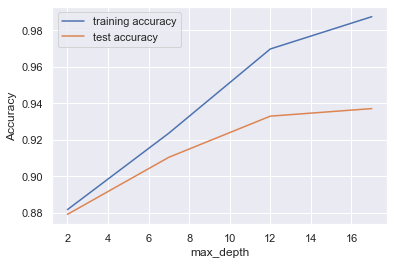

In [150]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#10,12

In [151]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1000, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1, return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=10),
             n_jobs=-1, param_grid={'n_estimators': range(100, 1000, 400)},
             return_train_score=True, scoring='accuracy')

In [152]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.531383,0.018888,0.082979,0.002475,100,{'n_estimators': 100},0.919705,0.924232,0.934715,0.930903,0.925423,0.926995,0.005256,3,0.958363,0.958840,0.955861,0.953896,0.956338,0.956660,0.001791
1,19.466252,0.168863,0.326764,0.023724,500,{'n_estimators': 500},0.919705,0.925899,0.934239,0.931618,0.926853,0.927663,0.005020,1,0.958006,0.957827,0.956457,0.955742,0.957767,0.957160,0.000898
2,30.873782,0.088655,0.371975,0.003602,900,{'n_estimators': 900},0.920419,0.924946,0.934477,0.929950,0.927091,0.927377,0.004721,2,0.958006,0.958244,0.957053,0.955206,0.958304,0.957362,0.001168


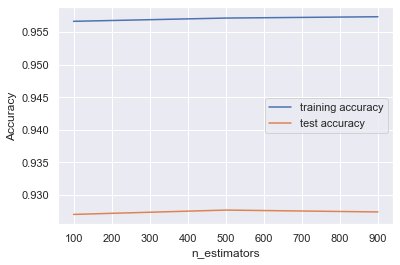

In [153]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [154]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=10),
             param_grid={'max_features': [4, 8, 14, 20, 24]},
             return_train_score=True, scoring='accuracy')

In [155]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.310748,0.010966,0.041766,0.000381,4,{'max_features': 4},0.915178,0.922564,0.929473,0.927567,0.921372,0.923231,0.005031,5,0.951334,0.949309,0.948177,0.947522,0.949905,0.949249,0.001335
1,2.344603,0.024461,0.040999,0.000606,8,{'max_features': 8},0.918275,0.926614,0.932571,0.931618,0.927567,0.927329,0.005068,2,0.957589,0.956397,0.955504,0.954432,0.955623,0.955909,0.001048
2,3.904621,0.020711,0.039018,0.000128,14,{'max_features': 14},0.920896,0.924708,0.935430,0.928759,0.930426,0.928044,0.004959,1,0.960627,0.959971,0.958780,0.959197,0.957529,0.959221,0.001058
3,5.449568,0.048590,0.038439,0.000429,20,{'max_features': 20},0.918751,0.921849,0.932333,0.930188,0.930188,0.926662,0.005344,3,0.961222,0.959495,0.959376,0.959078,0.959614,0.959757,0.000754
4,6.474078,0.017590,0.037996,0.000655,24,{'max_features': 24},0.918751,0.920181,0.933286,0.929712,0.930426,0.926471,0.005861,4,0.960627,0.958840,0.959316,0.960091,0.960567,0.959888,0.000703


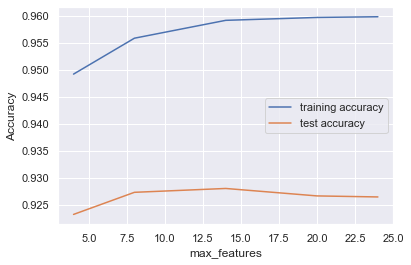

In [156]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [157]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'min_samples_leaf': range(100, 400, 50)},
             return_train_score=True, scoring='accuracy')

In [158]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.008602,0.036811,0.037357,0.000502,100,{'min_samples_leaf': 100},0.886347,0.883488,0.888968,0.892781,0.891351,0.888587,0.003358,1,0.897486,0.898439,0.894448,0.892542,0.893317,0.895247,0.002319
1,1.866707,0.033295,0.035901,0.000012,150,{'min_samples_leaf': 150},0.881106,0.880152,0.883488,0.886824,0.887300,0.883774,0.002900,2,0.890338,0.888373,0.887062,0.887062,0.888075,0.888182,0.001200
2,1.700447,0.018844,0.034191,0.000371,200,{'min_samples_leaf': 200},0.874434,0.878008,0.879676,0.878008,0.883012,0.878628,0.002781,3,0.884620,0.886288,0.884024,0.880391,0.880927,0.883250,0.002248
3,1.634205,0.015369,0.034304,0.002810,250,{'min_samples_leaf': 250},0.875149,0.878723,0.874196,0.877532,0.880867,0.877293,0.002411,4,0.883012,0.884977,0.878782,0.878425,0.879616,0.880963,0.002582
4,1.536630,0.006093,0.032743,0.000739,300,{'min_samples_leaf': 300},0.867048,0.871813,0.873243,0.877532,0.881106,0.874148,0.004828,6,0.877412,0.878604,0.875387,0.880986,0.876102,0.877698,0.001980


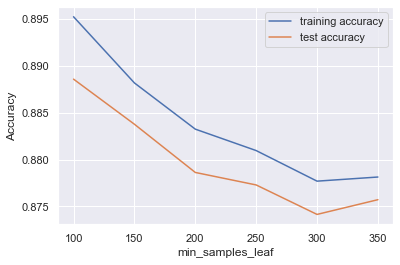

In [159]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [160]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 700, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'min_samples_split': range(100, 700, 50)},
             return_train_score=True, scoring='accuracy')

In [161]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.644818,0.044568,0.043515,0.000802,100,{'min_samples_split': 100},0.908030,0.908983,0.918037,0.921372,0.914224,0.914129,0.005127,1,0.937098,0.934656,0.930843,0.933226,0.935490,0.934263,0.002120
1,2.535439,0.021671,0.041061,0.000624,150,{'min_samples_split': 150},0.898261,0.900882,0.911604,0.913986,0.909697,0.906886,0.006181,2,0.924232,0.921909,0.918751,0.920598,0.923159,0.921730,0.001923
2,2.453909,0.048471,0.040118,0.000381,200,{'min_samples_split': 200},0.892781,0.893972,0.901596,0.904456,0.900882,0.898737,0.004553,3,0.913807,0.911306,0.907970,0.912020,0.911663,0.911353,0.001898
3,2.372978,0.017098,0.038770,0.000439,250,{'min_samples_split': 250},0.893734,0.888015,0.898975,0.900643,0.898261,0.895926,0.004569,4,0.909876,0.907255,0.900286,0.904098,0.902490,0.904801,0.003406
4,2.292847,0.015229,0.037861,0.000486,300,{'min_samples_split': 300},0.890636,0.883012,0.893495,0.893734,0.892542,0.890684,0.003988,5,0.905647,0.899214,0.896235,0.896950,0.898797,0.899369,0.003330


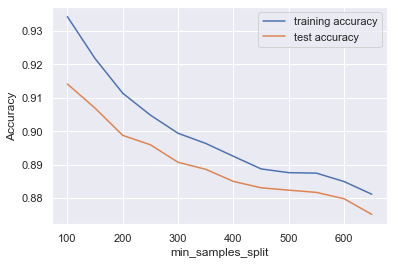

In [162]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [163]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,12],
    'min_samples_leaf': range(150, 250, 50),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': [300,400,500], 
    'max_features': [15, 20]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 3, verbose = 1, n_jobs=-1, return_train_score=True)

In [164]:
# fit
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  3.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [10, 12], 'max_features': [15, 20],
                         'min_samples_leaf': range(150, 250, 50),
                         'min_samples_split': range(200, 400, 100),
                         'n_estimators': [300, 400, 500]},
             refit='recall_score', return_train_score=True, verbose=1)

- printing the optimal accuracy score and hyperparameters

In [165]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8756254467476768 using {'max_depth': 12, 'max_features': 15, 'min_samples_leaf': 150, 'min_samples_split': 300, 'n_estimators': 300}


In [166]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc_final = RandomForestClassifier(bootstrap=True,class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=150, 
                             min_samples_split=300,
                             max_features=15,
                             n_estimators=500)

In [167]:
# fit
rfc_final.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=15,
                       min_samples_leaf=150, min_samples_split=300,
                       n_estimators=500)

In [168]:
# predict
predictions = rfc_final.predict(X_test)

In [169]:
from sklearn import metrics
confusion_rm_f = metrics.confusion_matrix( y_test, predictions )
confusion_rm_f

array([[7160, 1019],
       [ 140,  675]], dtype=int64)

In [170]:
TN = confusion_rm_f[0,0] # true positive 
TP = confusion_rm_f[1,1] # true negatives
FP = confusion_rm_f[0,1] # false positives
FN = confusion_rm_f[1,0] # false negatives

print('Accuracy Score: ',accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score:  0.8711363130976206
Sensitivity:  0.8282208588957055
Specificity:  0.87541264213229
false postive rate:  0.12458735786770998
positive predictive value:  0.3984651711924439
Negative predictive value:  0.9808219178082191
Misclassification Rate:  0.12886368690237937


### RandomForest model Observations to be added 

In [171]:
#Important Variables
from collections import OrderedDict
feature_names=list(X_train.columns.values)
important_features_dict = {}
for name, importance in zip(feature_names, rfc_final.feature_importances_):
    important_features_dict[name]=importance
#Sorting Dictionary in descending order of the importance variable
d_descending = OrderedDict(sorted(important_features_dict.items(), 
                                  key=lambda kv: kv[1], reverse=True))

In [172]:
telecom_df5.columns

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'isd_og_mou_6', 'spl_og_mou_6', 'spl_og_mou_7',
       'spl_og_mou_8', 'og_others_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_t2f_mou_8', 'isd_ic_mou_6', 'ic_others_6', 'ic_others_7',
       'ic_others_8', 'total_rech_num_6', 'total_rech_num_7', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'date_of_last_rech_6',
       'date_of_last_rech_7', 'date_of_last_rech_8', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'monthly_2g_6',
       'mont

In [173]:
#Variable Importance top 30 variable
dic= dict(d_descending)

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n=12
n_items = take(n, dic.items())

In [174]:
print('These are top 12 driver variable: ',n_items)

These are top 12 driver variable:  [('arpu_8', 0.26630774859213013), ('last_day_rch_amt_8', 0.17841963904232847), ('roam_ic_mou_8', 0.13650812668966703), ('max_rech_amt_8', 0.12836555724700704), ('date_of_last_rech_8', 0.07673294459998817), ('spl_og_mou_8', 0.0290392224561527), ('std_ic_t2f_mou_8', 0.02074451621007598), ('roam_ic_mou_7', 0.013904476424378637), ('loc_og_t2f_mou_6', 0.01224002672411789), ('arpu_7', 0.011127816930246351), ('loc_ic_t2f_mou_6', 0.010580523647996408), ('aug_vbc_3g', 0.010159345944304937)]


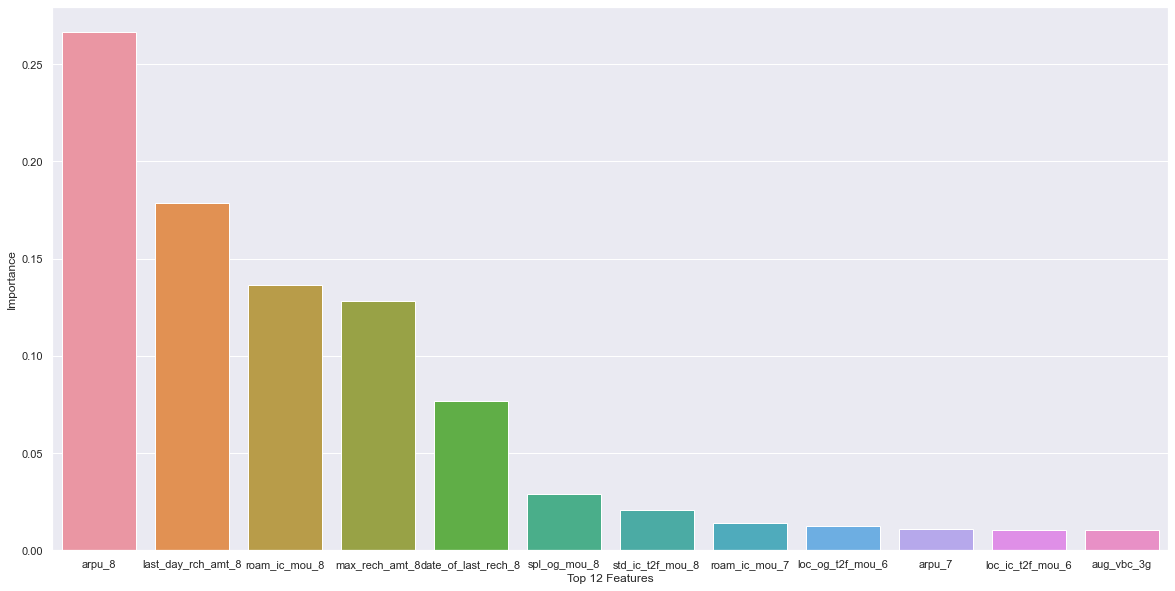

In [175]:
imp=rfc_final.feature_importances_
names=X_train.columns.values
imp,names=zip(*sorted(zip(imp,names)))

df_1=pd.DataFrame({"Variable":names,"importance":imp})
df_2 = df_1.sort_values(by="importance",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)


plt.figure(figsize=(20, 10))

ax = sns.barplot(x='Variable', y= 'importance', data=df_2[0:12])
ax.set(xlabel = 'Top 12 Features', ylabel = 'Importance')
plt.show()

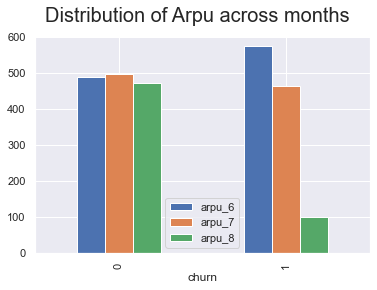

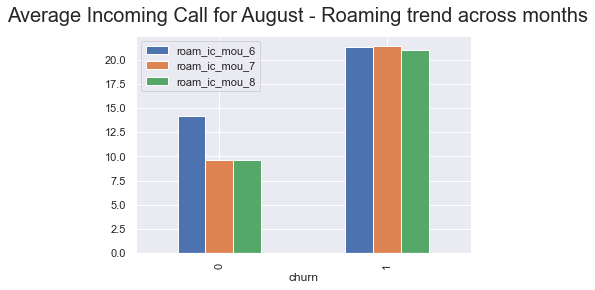

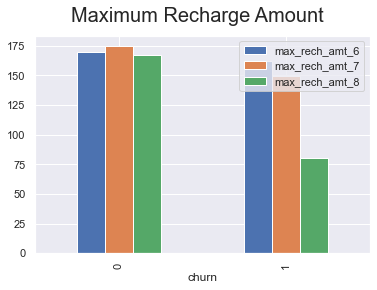

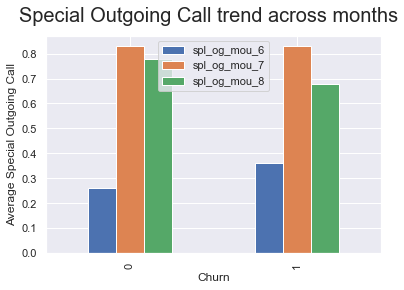

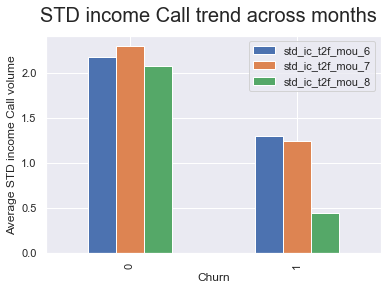

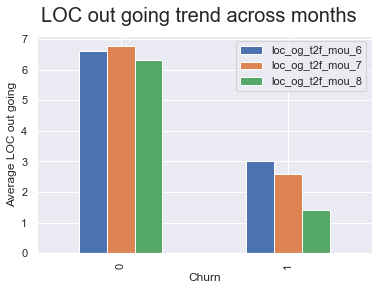

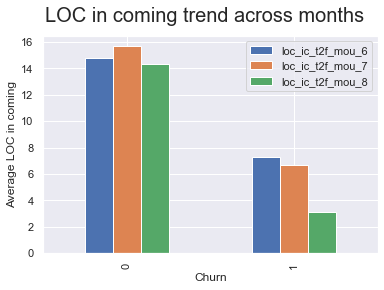

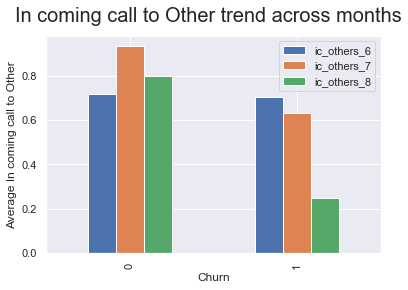

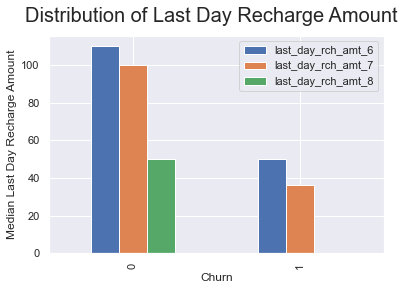

In [176]:
telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['arpu_6', 'arpu_7', 'arpu_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Arpu across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('Average Incoming Call for August - Roaming trend across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8'].mean()
df_sample.plot.bar()
plt.suptitle('Maximum Recharge Amount', fontsize=20)
plt.show()


df_sample = telecom_df2.groupby(['churn'])['spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8'].median()
df_sample.plot.bar()
plt.suptitle('Special Outgoing Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average Special Outgoing Call")
plt.show()


df_sample = telecom_df2.groupby(['churn'])['std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('STD income Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average STD income Call volume")
plt.show()


df_sample = telecom_df2.groupby(['churn'])['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC out going trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC out going")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC in coming trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC in coming")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['ic_others_6', 'ic_others_7', 'ic_others_8'].mean()
df_sample.plot.bar()
plt.suptitle('In coming call to Other trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average In coming call to Other")
plt.show()

telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Last Day Recharge Amount', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Median Last Day Recharge Amount")
plt.show()

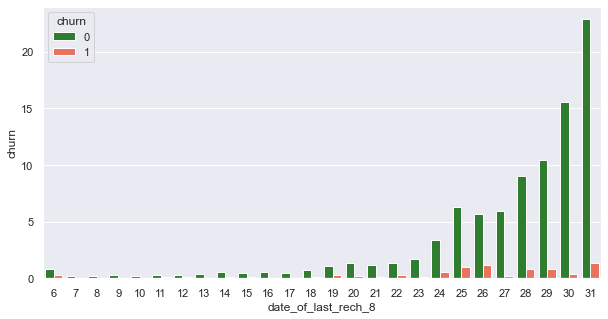

In [177]:

plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

# END OF FILE